<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Code-Setup" data-toc-modified-id="Code-Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Code Setup</a></span><ul class="toc-item"><li><span><a href="#Summary-of-changes" data-toc-modified-id="Summary-of-changes-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Summary of changes</a></span></li><li><span><a href="#Acronyms-and-abbreviations" data-toc-modified-id="Acronyms-and-abbreviations-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Acronyms and abbreviations</a></span></li></ul></li><li><span><a href="#Establish-Data-Frames" data-toc-modified-id="Establish-Data-Frames-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Establish Data Frames</a></span><ul class="toc-item"><li><span><a href="#Read-in-data" data-toc-modified-id="Read-in-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Read in data</a></span></li><li><span><a href="#Random-unsupervised-augmentation" data-toc-modified-id="Random-unsupervised-augmentation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Random unsupervised augmentation</a></span><ul class="toc-item"><li><span><a href="#1:200-ENM-organics-data" data-toc-modified-id="1:200-ENM-organics-data-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>1:200 ENM-organics data</a></span></li><li><span><a href="#1:100-ENM-organics-data" data-toc-modified-id="1:100-ENM-organics-data-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>1:100 ENM-organics data</a></span></li><li><span><a href="#1:50-ENM-organics-data" data-toc-modified-id="1:50-ENM-organics-data-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>1:50 ENM-organics data</a></span></li><li><span><a href="#1:20-ENM-organics-data" data-toc-modified-id="1:20-ENM-organics-data-2.2.4"><span class="toc-item-num">2.2.4&nbsp;&nbsp;</span>1:20 ENM-organics data</a></span></li><li><span><a href="#1:10-ENM-organics-data" data-toc-modified-id="1:10-ENM-organics-data-2.2.5"><span class="toc-item-num">2.2.5&nbsp;&nbsp;</span>1:10 ENM-organics data</a></span></li><li><span><a href="#1:5-ENM-organics-data" data-toc-modified-id="1:5-ENM-organics-data-2.2.6"><span class="toc-item-num">2.2.6&nbsp;&nbsp;</span>1:5 ENM-organics data</a></span></li><li><span><a href="#1:4-ENM-organics-data" data-toc-modified-id="1:4-ENM-organics-data-2.2.7"><span class="toc-item-num">2.2.7&nbsp;&nbsp;</span>1:4 ENM-organics data</a></span></li><li><span><a href="#1:3-ENM-organics-data" data-toc-modified-id="1:3-ENM-organics-data-2.2.8"><span class="toc-item-num">2.2.8&nbsp;&nbsp;</span>1:3 ENM-organics data</a></span></li><li><span><a href="#1:2-ENM-organics-data" data-toc-modified-id="1:2-ENM-organics-data-2.2.9"><span class="toc-item-num">2.2.9&nbsp;&nbsp;</span>1:2 ENM-organics data</a></span></li><li><span><a href="#1:1-ENM-organics-data" data-toc-modified-id="1:1-ENM-organics-data-2.2.10"><span class="toc-item-num">2.2.10&nbsp;&nbsp;</span>1:1 ENM-organics data</a></span></li><li><span><a href="#Apply-WF-bins" data-toc-modified-id="Apply-WF-bins-2.2.11"><span class="toc-item-num">2.2.11&nbsp;&nbsp;</span>Apply WF bins</a></span></li></ul></li><li><span><a href="#WF-Permutation" data-toc-modified-id="WF-Permutation-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>WF Permutation</a></span></li><li><span><a href="#Matching-unsupervised-augmentation" data-toc-modified-id="Matching-unsupervised-augmentation-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Matching unsupervised augmentation</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data-frames" data-toc-modified-id="Data-frames-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Data frames</a></span></li></ul></li><li><span><a href="#Matching-supervised-augmentation" data-toc-modified-id="Matching-supervised-augmentation-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Matching supervised augmentation</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Data-frames" data-toc-modified-id="Data-frames-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Data frames</a></span></li></ul></li></ul></li><li><span><a href="#Model-selection" data-toc-modified-id="Model-selection-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model selection</a></span></li><li><span><a href="#SVC-Models" data-toc-modified-id="SVC-Models-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>SVC Models</a></span><ul class="toc-item"><li><span><a href="#Functions" data-toc-modified-id="Functions-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#ENM-only" data-toc-modified-id="ENM-only-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>ENM-only</a></span></li><li><span><a href="#ENM-only-permutations" data-toc-modified-id="ENM-only-permutations-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>ENM-only permutations</a></span></li><li><span><a href="#1:200-ENM-organics-data" data-toc-modified-id="1:200-ENM-organics-data-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>1:200 ENM-organics data</a></span></li><li><span><a href="#1:100-ENM-organics-data" data-toc-modified-id="1:100-ENM-organics-data-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>1:100 ENM-organics data</a></span></li><li><span><a href="#1:50-ENM-organics-data" data-toc-modified-id="1:50-ENM-organics-data-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>1:50 ENM-organics data</a></span></li><li><span><a href="#1:20-ENM-organics-data" data-toc-modified-id="1:20-ENM-organics-data-4.7"><span class="toc-item-num">4.7&nbsp;&nbsp;</span>1:20 ENM-organics data</a></span></li><li><span><a href="#1:10-ENM-organics-data" data-toc-modified-id="1:10-ENM-organics-data-4.8"><span class="toc-item-num">4.8&nbsp;&nbsp;</span>1:10 ENM-organics data</a></span></li><li><span><a href="#1:5-ENM-organics-data" data-toc-modified-id="1:5-ENM-organics-data-4.9"><span class="toc-item-num">4.9&nbsp;&nbsp;</span>1:5 ENM-organics data</a></span></li><li><span><a href="#1:4-ENM-organics-data" data-toc-modified-id="1:4-ENM-organics-data-4.10"><span class="toc-item-num">4.10&nbsp;&nbsp;</span>1:4 ENM-organics data</a></span></li><li><span><a href="#1:3-ENM-organics-data" data-toc-modified-id="1:3-ENM-organics-data-4.11"><span class="toc-item-num">4.11&nbsp;&nbsp;</span>1:3 ENM-organics data</a></span></li><li><span><a href="#1:2-ENM-organics-data" data-toc-modified-id="1:2-ENM-organics-data-4.12"><span class="toc-item-num">4.12&nbsp;&nbsp;</span>1:2 ENM-organics data</a></span></li><li><span><a href="#1:1-ENM-organics-data" data-toc-modified-id="1:1-ENM-organics-data-4.13"><span class="toc-item-num">4.13&nbsp;&nbsp;</span>1:1 ENM-organics data</a></span></li><li><span><a href="#Matching-1:50" data-toc-modified-id="Matching-1:50-4.14"><span class="toc-item-num">4.14&nbsp;&nbsp;</span>Matching 1:50</a></span></li><li><span><a href="#Matching-1:20" data-toc-modified-id="Matching-1:20-4.15"><span class="toc-item-num">4.15&nbsp;&nbsp;</span>Matching 1:20</a></span></li><li><span><a href="#Matching-1:10" data-toc-modified-id="Matching-1:10-4.16"><span class="toc-item-num">4.16&nbsp;&nbsp;</span>Matching 1:10</a></span></li><li><span><a href="#Matching-1:5" data-toc-modified-id="Matching-1:5-4.17"><span class="toc-item-num">4.17&nbsp;&nbsp;</span>Matching 1:5</a></span></li><li><span><a href="#Matching-1:4" data-toc-modified-id="Matching-1:4-4.18"><span class="toc-item-num">4.18&nbsp;&nbsp;</span>Matching 1:4</a></span></li><li><span><a href="#Matching-1:3" data-toc-modified-id="Matching-1:3-4.19"><span class="toc-item-num">4.19&nbsp;&nbsp;</span>Matching 1:3</a></span></li><li><span><a href="#Matching-1:2" data-toc-modified-id="Matching-1:2-4.20"><span class="toc-item-num">4.20&nbsp;&nbsp;</span>Matching 1:2</a></span></li><li><span><a href="#Matching-1:1" data-toc-modified-id="Matching-1:1-4.21"><span class="toc-item-num">4.21&nbsp;&nbsp;</span>Matching 1:1</a></span></li><li><span><a href="#Matching-label-1:50" data-toc-modified-id="Matching-label-1:50-4.22"><span class="toc-item-num">4.22&nbsp;&nbsp;</span>Matching label 1:50</a></span></li><li><span><a href="#Matching-label-1:20" data-toc-modified-id="Matching-label-1:20-4.23"><span class="toc-item-num">4.23&nbsp;&nbsp;</span>Matching label 1:20</a></span></li><li><span><a href="#Matching-label-1:10" data-toc-modified-id="Matching-label-1:10-4.24"><span class="toc-item-num">4.24&nbsp;&nbsp;</span>Matching label 1:10</a></span></li><li><span><a href="#Matching-label-1:5" data-toc-modified-id="Matching-label-1:5-4.25"><span class="toc-item-num">4.25&nbsp;&nbsp;</span>Matching label 1:5</a></span></li><li><span><a href="#Matching-label-1:4" data-toc-modified-id="Matching-label-1:4-4.26"><span class="toc-item-num">4.26&nbsp;&nbsp;</span>Matching label 1:4</a></span></li><li><span><a href="#Matching-label-1:3" data-toc-modified-id="Matching-label-1:3-4.27"><span class="toc-item-num">4.27&nbsp;&nbsp;</span>Matching label 1:3</a></span></li><li><span><a href="#Matching-label-1:2" data-toc-modified-id="Matching-label-1:2-4.28"><span class="toc-item-num">4.28&nbsp;&nbsp;</span>Matching label 1:2</a></span></li><li><span><a href="#Matching-label-1:1" data-toc-modified-id="Matching-label-1:1-4.29"><span class="toc-item-num">4.29&nbsp;&nbsp;</span>Matching label 1:1</a></span></li><li><span><a href="#Performance-Results" data-toc-modified-id="Performance-Results-4.30"><span class="toc-item-num">4.30&nbsp;&nbsp;</span>Performance Results</a></span></li></ul></li><li><span><a href="#Random-Forest-Models" data-toc-modified-id="Random-Forest-Models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Random Forest Models</a></span></li></ul></div>

# Code Setup

## Summary of changes

###### Changes since 1/25/19:
* Now writes model evaluation results directly to table
* Permutation tests with ENM-only model
* Changed SVC-RBF parameter grid from running:
    * c_set = np.logspace(0,5,20)
    * gamma_set = np.logspace(-6,0,16)
* To running:
    * c_set = np.logspace(-1,6,15), 
    * gamma_set = np.logspace(-6,1,15))
* Changed random state for SVC-RBF from 24 to 42

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os

In [2]:
# to make this notebook's output stable across runs
np.random.seed(42)

In [3]:
# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

In [4]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
PROJECT_SAVE_DIR = "BLTfigs"

In [5]:
import os
#os.chdir(path)
if not (os.path.isdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)):
    print('Figure directory did not exist, creating now.')
    os.mkdir(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR)
else:
    print('Figure directory exists.')

Figure directory exists.


In [6]:
#def savepdf(fig,name):
#    fig.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+name+'.pdf')

In [7]:
# To enable a specified sound to play
from IPython.display import Audio
sound_file = './data/Glass.wav'

# Add the following to the end of a cell with a long run time
# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

In [8]:
# Shift tab to understand function components
# Type questionmark before function to bring up help

## Acronyms and abbreviations

* arr = array
* bp = boiling point
* cv = cross validation
* df = data frame
* enm = engineered nanomaterials
* matrix_F = matrix of the product is a formulation (i.e., not a solid)
* mp = melting point
* mw = molecular weight
* oecd = Organisation for Economic Co-operation and Development
* prop = property
* puc = product use category
* rbf = radial basis function (a non-linear implementation of SVM)
* svc = support vector classifier (for categorical data)
* svm = support vector machine
* wf = weight fraction

# Establish Data Frames

## Read in data

Read in ENM and organics feature data.

In [9]:
# Read in target (ENM) model feature data
    # Numbered columns are clustered chemical function groups
X_enm = pd.read_csv("./data/XX_enm.csv", sep='\t', header='infer', index_col=0)
X_enm.head(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
0,79.867,1843.00,2972.0,0.626340,0.5,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
1,63.546,1083.00,2567.0,0.952308,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,65.370,419.53,907.0,0.853698,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,107.868,961.78,2162.0,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1


In [10]:
# Read in source (organics) model feature data
X_source = pd.read_csv("./data/XX_source.csv", sep='\t', header='infer', index_col=0)
X_source.head(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
1,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
2,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
3,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1
4,106.168,-52.5218,147.1505,-0.05061,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,1,1


In [11]:
print(X_source.shape)

(16354, 39)


Read in ENM and organics WF (label) data.

In [12]:
# Read in ENM maximum_weight_fraction data
y_enm = pd.read_csv("./data/ENM_conc_export.csv", sep=',', header='infer', usecols=[3])

In [13]:
# Read in organics maximum_weight_fraction data
y_source = pd.read_csv("./data/y_source.csv", sep=',', header='infer')
y_source.index = X_source.index

Read in previous model evaluation results.

In [231]:
# Read in results table
results_df = pd.read_csv("./data/2019-02-18_augment_results.csv", sep='\t')
# Change column of ratios to strings
results_df['ENM-Organics-Ratio'] = results_df['ENM-Organics-Ratio'].astype(str)

## Random unsupervised augmentation

ENM data is augmented with randomly sampled organics data to see if model performance is improved. Multiple data frames are constructed for testing prediction models with varying ratios of ENM:organics data.

In [15]:
# Define function to augment ENM data with random organics data

def augment(source_data, 
            enm_data, 
            n_samples, 
            random_state):
    
    # Sample source (organics) data
    df_samples = source_data.sample(n=n_samples, replace=False, 
                            random_state=random_state, axis=0)
    
    # Append sampled organics data to ENM data
    df_concat = pd.concat([enm_data, df_samples], sort=False)
    
    print('Shape of concatenated df: ', df_concat.shape)
    
    return df_concat

### 1:200 ENM-organics data

In [16]:
# ENM and all organics data stacked, respectively
X_all = pd.concat([X_enm, X_source], sort=False)
y_all = pd.concat([y_enm, y_source])

print(X_all.shape)
print(y_all.shape)

(16436, 39)
(16436, 1)


In [17]:
X_all.tail(4)

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
29366,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
29367,152.149,84.03215,263.941,0.078457,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,1
29368,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
29369,135.210,-31.78080,203.080,-0.031517,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
y_all.tail(4)

,maximum_weight_fraction
29366,0.01
29367,0.01
29368,0.02
29369,0.02


### 1:100 ENM-organics data

In [19]:
# Randomly sample 50% of organics data
X_oneto100a = augment(X_source, X_enm,
                    n_samples=8200,
                    random_state=50)
y_oneto100a = augment(y_source, y_enm,
                    n_samples=8200,
                    random_state=50)

Shape of concatenated df:  (8282, 39)
Shape of concatenated df:  (8282, 1)


In [20]:
X_oneto100a.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.00000,2972.00000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.78000,2162.00000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
21462,342.297,159.24950,379.30850,0.240300,0.0,0.0,0.5,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
13861,152.237,10.86245,221.57100,-0.061981,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
19309,60.096,-71.42240,86.55995,-0.063989,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
y_oneto100a.iloc[80:85,:]

,maximum_weight_fraction
80,0.000667
81,0.000800
21462,0.300000
13861,0.050000
19309,0.050000


In [22]:
# Randomly sample 50% of organics data
X_oneto100b = augment(X_source, X_enm,
                    n_samples=8200,
                    random_state=60)
y_oneto100b = augment(y_source, y_enm,
                    n_samples=8200,
                    random_state=60)

Shape of concatenated df:  (8282, 39)
Shape of concatenated df:  (8282, 1)


In [23]:
# Randomly sample 50% of organics data
X_oneto100c = augment(X_source, X_enm,
                    n_samples=8200,
                    random_state=70)
y_oneto100c = augment(y_source, y_enm,
                    n_samples=8200,
                    random_state=70)

Shape of concatenated df:  (8282, 39)
Shape of concatenated df:  (8282, 1)


### 1:50 ENM-organics data

In [24]:
# Randomly sample 25% of organics data
X_oneto50a = augment(X_source, X_enm,
                    n_samples=4100,
                    random_state=45)
y_oneto50a = augment(y_source, y_enm,
                    n_samples=4100,
                    random_state=45)

Shape of concatenated df:  (4182, 39)
Shape of concatenated df:  (4182, 1)


In [25]:
# Randomly sample 25% of organics data again
X_oneto50b = augment(X_source, X_enm,
                    n_samples=4100,
                    random_state=12)
y_oneto50b = augment(y_source, y_enm,
                    n_samples=4100,
                    random_state=12)

Shape of concatenated df:  (4182, 39)
Shape of concatenated df:  (4182, 1)


In [26]:
# Randomly sample 25% of organics data again
X_oneto50c = augment(X_source, X_enm,
                    n_samples=4100,
                    random_state=55)
y_oneto50c = augment(y_source, y_enm,
                    n_samples=4100,
                    random_state=55)

Shape of concatenated df:  (4182, 39)
Shape of concatenated df:  (4182, 1)


### 1:20 ENM-organics data

In [27]:
# Randomly sample 10% of organics data
X_oneto20a = augment(X_source, X_enm,
                    n_samples=1640,
                    random_state=42)
y_oneto20a = augment(y_source, y_enm,
                    n_samples=1640,
                    random_state=42)

Shape of concatenated df:  (1722, 39)
Shape of concatenated df:  (1722, 1)


In [28]:
# Randomly sample 10% of organics data
X_oneto20b = augment(X_source, X_enm,
                    n_samples=1640,
                    random_state=52)
y_oneto20b = augment(y_source, y_enm,
                    n_samples=1640,
                    random_state=52)

Shape of concatenated df:  (1722, 39)
Shape of concatenated df:  (1722, 1)


In [29]:
# Randomly sample 10% of organics data
X_oneto20c = augment(X_source, X_enm,
                    n_samples=1640,
                    random_state=62)
y_oneto20c = augment(y_source, y_enm,
                    n_samples=1640,
                    random_state=62)

Shape of concatenated df:  (1722, 39)
Shape of concatenated df:  (1722, 1)


### 1:10 ENM-organics data

In [30]:
# Randomly sample 5% of organics data
X_oneto10a = augment(X_source, X_enm,
                    n_samples=820,
                    random_state=40)
y_oneto10a = augment(y_source, y_enm,
                    n_samples=820,
                    random_state=40)

Shape of concatenated df:  (902, 39)
Shape of concatenated df:  (902, 1)


In [31]:
# Randomly sample 5% of organics data
X_oneto10b = augment(X_source, X_enm,
                    n_samples=820,
                    random_state=30)
y_oneto10b = augment(y_source, y_enm,
                    n_samples=820,
                    random_state=30)

Shape of concatenated df:  (902, 39)
Shape of concatenated df:  (902, 1)


In [32]:
# Randomly sample 5% of organics data
X_oneto10c = augment(X_source, X_enm,
                    n_samples=820,
                    random_state=20)
y_oneto10c = augment(y_source, y_enm,
                    n_samples=820,
                    random_state=20)

Shape of concatenated df:  (902, 39)
Shape of concatenated df:  (902, 1)


### 1:5 ENM-organics data

In [33]:
# Randomly sample 2.5% of organics data
X_oneto5a = augment(X_source, X_enm,
                    n_samples=410,
                    random_state=35)
y_oneto5a = augment(y_source, y_enm,
                    n_samples=410,
                    random_state=35)

Shape of concatenated df:  (492, 39)
Shape of concatenated df:  (492, 1)


In [34]:
# Randomly sample 2.5% of organics data
X_oneto5b = augment(X_source, X_enm,
                    n_samples=410,
                    random_state=25)
y_oneto5b = augment(y_source, y_enm,
                    n_samples=410,
                    random_state=25)

Shape of concatenated df:  (492, 39)
Shape of concatenated df:  (492, 1)


In [35]:
# Randomly sample 2.5% of organics data
X_oneto5c = augment(X_source, X_enm,
                    n_samples=410,
                    random_state=15)
y_oneto5c = augment(y_source, y_enm,
                    n_samples=410,
                    random_state=15)

Shape of concatenated df:  (492, 39)
Shape of concatenated df:  (492, 1)


### 1:4 ENM-organics data

In [36]:
# Randomly sample 2% of organics data
X_oneto4a = augment(X_source, X_enm,
                    n_samples=328,
                    random_state=34)
y_oneto4a = augment(y_source, y_enm,
                    n_samples=328,
                    random_state=34)

Shape of concatenated df:  (410, 39)
Shape of concatenated df:  (410, 1)


In [37]:
# Randomly sample 2% of organics data
X_oneto4b = augment(X_source, X_enm,
                    n_samples=328,
                    random_state=24)
y_oneto4b = augment(y_source, y_enm,
                    n_samples=328,
                    random_state=24)

Shape of concatenated df:  (410, 39)
Shape of concatenated df:  (410, 1)


In [38]:
# Randomly sample 2% of organics data
X_oneto4c = augment(X_source, X_enm,
                    n_samples=328,
                    random_state=14)
y_oneto4c = augment(y_source, y_enm,
                    n_samples=328,
                    random_state=14)

Shape of concatenated df:  (410, 39)
Shape of concatenated df:  (410, 1)


### 1:3 ENM-organics data

In [39]:
# Randomly sample 1.5% of organics data
X_oneto3a = augment(X_source, X_enm,
                    n_samples=246,
                    random_state=33)
y_oneto3a = augment(y_source, y_enm,
                    n_samples=246,
                    random_state=33)

Shape of concatenated df:  (328, 39)
Shape of concatenated df:  (328, 1)


In [40]:
# Randomly sample 1.5% of organics data
X_oneto3b = augment(X_source, X_enm,
                    n_samples=246,
                    random_state=23)
y_oneto3b = augment(y_source, y_enm,
                    n_samples=246,
                    random_state=23)

Shape of concatenated df:  (328, 39)
Shape of concatenated df:  (328, 1)


In [41]:
# Randomly sample 1.5% of organics data
X_oneto3c = augment(X_source, X_enm,
                    n_samples=246,
                    random_state=13)
y_oneto3c = augment(y_source, y_enm,
                    n_samples=246,
                    random_state=13)

Shape of concatenated df:  (328, 39)
Shape of concatenated df:  (328, 1)


### 1:2 ENM-organics data

In [42]:
# Randomly sample 1% of organics data
X_oneto2a = augment(X_source, X_enm,
                    n_samples=164,
                    random_state=32)
y_oneto2a = augment(y_source, y_enm,
                    n_samples=164,
                    random_state=32)

Shape of concatenated df:  (246, 39)
Shape of concatenated df:  (246, 1)


In [43]:
# Randomly sample 1% of organics data
X_oneto2b = augment(X_source, X_enm,
                    n_samples=164,
                    random_state=22)
y_oneto2b = augment(y_source, y_enm,
                    n_samples=164,
                    random_state=22)

Shape of concatenated df:  (246, 39)
Shape of concatenated df:  (246, 1)


In [44]:
# Randomly sample 1% of organics data
X_oneto2c = augment(X_source, X_enm,
                    n_samples=164,
                    random_state=12)
y_oneto2c = augment(y_source, y_enm,
                    n_samples=164,
                    random_state=12)

Shape of concatenated df:  (246, 39)
Shape of concatenated df:  (246, 1)


### 1:1 ENM-organics data

In [45]:
# Randomly sample 0.5% of organics data
X_oneto1a = augment(X_source, X_enm,
                    n_samples=82,
                    random_state=31)
y_oneto1a = augment(y_source, y_enm,
                    n_samples=82,
                    random_state=31)

Shape of concatenated df:  (164, 39)
Shape of concatenated df:  (164, 1)


In [46]:
# Randomly sample 0.5% of organics data
X_oneto1b = augment(X_source, X_enm,
                    n_samples=82,
                    random_state=21)
y_oneto1b = augment(y_source, y_enm,
                    n_samples=82,
                    random_state=21)

Shape of concatenated df:  (164, 39)
Shape of concatenated df:  (164, 1)


In [47]:
# Randomly sample 0.5% of organics data
X_oneto1c = augment(X_source, X_enm,
                    n_samples=82,
                    random_state=11)
y_oneto1c = augment(y_source, y_enm,
                    n_samples=82,
                    random_state=11)

Shape of concatenated df:  (164, 39)
Shape of concatenated df:  (164, 1)


### Apply WF bins

In [48]:
# Define function to assign weight fractions to bins 
# (slightly different ranges from those used by Isaacs et al. 2016)
def bins(row):
    if row['maximum_weight_fraction'] <= 0.002:
        val = 'bottom'
    elif row['maximum_weight_fraction'] > 0.05:
        val = 'top'
    else:
        val = 'middle'
    return val

Text(0.5,1,'Frequency of ENM Weight Fraction Bins')

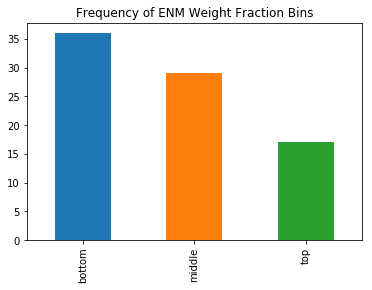

In [49]:
# Apply bins to ENM labels
bin_enm = y_enm.apply(bins, axis=1)

# View histogram of bins
bin_enm.value_counts().plot(kind='bar')
plt.title('Frequency of ENM Weight Fraction Bins')

In [50]:
# Use label encoder to make bins compatible with Scikit-Learn
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Fit the encoder and transform categories into integers
bin_enm = le.fit_transform(bin_enm)

Do the same for the organics WF data.

Text(0.5,1,'Frequency of Organics Weight Fraction Bins')

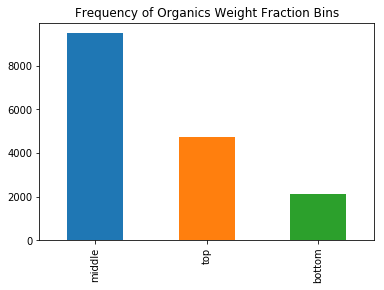

In [51]:
# Apply bins, label encoder to organics labels
bin_source = y_source.apply(bins, axis=1)

# View histogram of bins
bin_source.value_counts().plot(kind='bar')
plt.title('Frequency of Organics Weight Fraction Bins')

In [52]:
# Apply bins, label encoder to source WF data
bin_source = y_source.apply(bins, axis=1)
bin_source = le.fit_transform(bin_source)

print(bin_source.shape)
print(type(bin_source))

(16354,)
<class 'numpy.ndarray'>


Do the same for the augmented WF dfs.

In [53]:
# Apply bins, label encoder to all other WF data frames

# bin_all

bin_all = y_all.apply(bins, axis=1)
bin_all = le.fit_transform(bin_all)
print(bin_all.shape)

# bin_oneto100

bin_oneto100a = y_oneto100a.apply(bins, axis=1)
bin_oneto100a = le.fit_transform(bin_oneto100a)
print(bin_oneto100a.shape)

bin_oneto100b = y_oneto100b.apply(bins, axis=1)
bin_oneto100b = le.fit_transform(bin_oneto100b)
print(bin_oneto100b.shape)

bin_oneto100c = y_oneto100c.apply(bins, axis=1)
bin_oneto100c = le.fit_transform(bin_oneto100c)
print(bin_oneto100c.shape)

# bin_oneto50

bin_oneto50a = y_oneto50a.apply(bins, axis=1)
bin_oneto50a = le.fit_transform(bin_oneto50a)
print(bin_oneto50a.shape)

bin_oneto50b = y_oneto50b.apply(bins, axis=1)
bin_oneto50b = le.fit_transform(bin_oneto50b)
print(bin_oneto50b.shape)

bin_oneto50c = y_oneto50c.apply(bins, axis=1)
bin_oneto50c = le.fit_transform(bin_oneto50c)
print(bin_oneto50c.shape)

# bin_oneto20

bin_oneto20a = y_oneto20a.apply(bins, axis=1)
bin_oneto20a = le.fit_transform(bin_oneto20a)
print(bin_oneto20a.shape)

bin_oneto20b = y_oneto20b.apply(bins, axis=1)
bin_oneto20b = le.fit_transform(bin_oneto20b)
print(bin_oneto20b.shape)

bin_oneto20c = y_oneto20c.apply(bins, axis=1)
bin_oneto20c = le.fit_transform(bin_oneto20c)
print(bin_oneto20c.shape)

# bin_oneto10

bin_oneto10a = y_oneto10a.apply(bins, axis=1)
bin_oneto10a = le.fit_transform(bin_oneto10a)
print(bin_oneto10a.shape)

bin_oneto10b = y_oneto10b.apply(bins, axis=1)
bin_oneto10b = le.fit_transform(bin_oneto10b)
print(bin_oneto10b.shape)

bin_oneto10c = y_oneto10c.apply(bins, axis=1)
bin_oneto10c = le.fit_transform(bin_oneto10c)
print(bin_oneto10c.shape)

# bin_oneto5

bin_oneto5a = y_oneto5a.apply(bins, axis=1)
bin_oneto5a = le.fit_transform(bin_oneto5a)
print(bin_oneto5a.shape)

bin_oneto5b = y_oneto5b.apply(bins, axis=1)
bin_oneto5b = le.fit_transform(bin_oneto5b)
print(bin_oneto5b.shape)

bin_oneto5c = y_oneto5c.apply(bins, axis=1)
bin_oneto5c = le.fit_transform(bin_oneto5c)
print(bin_oneto5c.shape)

# bin_oneto4

bin_oneto4a = y_oneto4a.apply(bins, axis=1)
bin_oneto4a = le.fit_transform(bin_oneto4a)
print(bin_oneto4a.shape)

bin_oneto4b = y_oneto4b.apply(bins, axis=1)
bin_oneto4b = le.fit_transform(bin_oneto4b)
print(bin_oneto4b.shape)

bin_oneto4c = y_oneto4c.apply(bins, axis=1)
bin_oneto4c = le.fit_transform(bin_oneto4c)
print(bin_oneto4c.shape)

# bin_oneto3

bin_oneto3a = y_oneto3a.apply(bins, axis=1)
bin_oneto3a = le.fit_transform(bin_oneto3a)
print(bin_oneto3a.shape)

bin_oneto3b = y_oneto3b.apply(bins, axis=1)
bin_oneto3b = le.fit_transform(bin_oneto3b)
print(bin_oneto3b.shape)

bin_oneto3c = y_oneto3c.apply(bins, axis=1)
bin_oneto3c = le.fit_transform(bin_oneto3c)
print(bin_oneto3c.shape)

# bin_oneto2

bin_oneto2a = y_oneto2a.apply(bins, axis=1)
bin_oneto2a = le.fit_transform(bin_oneto2a)
print(bin_oneto2a.shape)

bin_oneto2b = y_oneto2b.apply(bins, axis=1)
bin_oneto2b = le.fit_transform(bin_oneto2b)
print(bin_oneto2b.shape)

bin_oneto2c = y_oneto2c.apply(bins, axis=1)
bin_oneto2c = le.fit_transform(bin_oneto2c)
print(bin_oneto2c.shape)

# bin_oneto1

bin_oneto1a = y_oneto1a.apply(bins, axis=1)
bin_oneto1a = le.fit_transform(bin_oneto1a)
print(bin_oneto1a.shape)

bin_oneto1b = y_oneto1b.apply(bins, axis=1)
bin_oneto1b = le.fit_transform(bin_oneto1b)
print(bin_oneto1b.shape)

bin_oneto1c = y_oneto1c.apply(bins, axis=1)
bin_oneto1c = le.fit_transform(bin_oneto1c)
print(bin_oneto1c.shape)

(16436,)
(8282,)
(8282,)
(8282,)
(4182,)
(4182,)
(4182,)
(1722,)
(1722,)
(1722,)
(902,)
(902,)
(902,)
(492,)
(492,)
(492,)
(410,)
(410,)
(410,)
(328,)
(328,)
(328,)
(246,)
(246,)
(246,)
(164,)
(164,)
(164,)


In [54]:
# Check distribution across WF bins
unique, counts = np.unique(bin_enm, return_counts=True)
dict(zip(unique, counts))

{0: 36, 1: 29, 2: 17}

The top WF bin (>5% ENM) has the least number of samples at 17. This is important for evaluating prediction models later on; I'll use 17 for the number of cross validation folds so that it's essentially "leave-one-out" cv. This approach is for the most part considered unbiased.

https://stats.stackexchange.com/questions/154830/10-fold-cross-validation-vs-leave-one-out-cross-validation

## WF Permutation

Create a data frame for permutation testing with only ENM data.  These results will serve as a baseline later.

In [55]:
# Create arrays with scrambled labels
bin_enm_permuteA = np.random.RandomState(seed=42).permutation(bin_enm)
bin_enm_permuteB = np.random.RandomState(seed=24).permutation(bin_enm)
bin_enm_permuteC = np.random.RandomState(seed=37).permutation(bin_enm)

In [56]:
bin_enm_permuteA

array([0, 2, 1, 0, 0, 0, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 0, 0, 2, 2, 0, 0,
       1, 2, 0, 1, 1, 2, 0, 0, 2, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 2, 0, 1, 1, 2, 0, 1, 1, 2, 1, 2, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 2, 0, 0, 2, 1, 1, 1, 1, 2, 2, 0, 1, 0, 1])

In [57]:
bin_enm_permuteB

array([2, 0, 1, 1, 1, 2, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0,
       0, 2, 0, 0, 0, 0, 1, 1, 2, 0, 2, 1, 0, 1, 1, 2, 1, 1, 1, 1, 2, 2,
       2, 0, 0, 2, 0, 1, 1, 1, 0, 1, 2, 1, 1, 2, 2, 0, 1, 1, 2, 0, 1, 0,
       2, 2, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0])

In [58]:
bin_enm_permuteC

array([0, 2, 0, 1, 1, 2, 2, 0, 1, 1, 2, 0, 0, 0, 1, 1, 0, 0, 0, 2, 0, 1,
       2, 1, 0, 2, 0, 1, 1, 2, 1, 1, 2, 1, 0, 0, 0, 1, 0, 0, 2, 0, 0, 2,
       0, 2, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 2, 2, 0, 1,
       1, 0, 2, 2, 1, 1, 0, 0, 0, 1, 1, 0, 1, 2, 1, 1])

In [59]:
bin_enm

array([2, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 2, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 0, 1, 0, 0])

## Matching unsupervised augmentation

### Setup

Instead of randomly selecting organics "tuples" to use for augmentation, the _kth_ closest tuples to each ENM tuple were selected, or "matched", based on cosine distance, or _1 - cosine similarity_.

Note: the use of "tuple" refers to a row of data describing an individual instance of one chemical used in one product, not the Python objects called "tuples".

References for implementing this section of code:
* https://stackoverflow.com/questions/34226400/find-the-index-of-the-k-smallest-values-of-a-numpy-array
* https://stackoverflow.com/questions/22117834/how-do-i-return-a-list-of-the-3-lowest-values-in-another-list
* http://dataaspirant.com/2015/04/11/five-most-popular-similarity-measures-implementation-in-python/
* https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html

In [60]:
# Scale/normalize data for computing distance
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
X_enm_scaled = pd.DataFrame(scaler.fit_transform(X_enm), 
                            columns = X_enm.columns, 
                            index = X_enm.index)
X_source_scaled = pd.DataFrame(scaler.fit_transform(X_source),
                             columns = X_source.columns,
                             index = X_source.index)

In [61]:
# Cosine similarity computes the L2-normalized dot product of vectors
# Cosine distance = 1 - cosine similarity
from sklearn.metrics.pairwise import cosine_distances

cosdist_feats = cosine_distances(X = X_source_scaled, 
                    Y = X_enm_scaled)
print(cosdist_feats.shape)

(16354, 82)


In [62]:
# Define function to match k most similar organics examples 
# to ENM examples based on smallest distance

def augment_match(k, dist_matrix): 
    
    idx_match = []
    
    # Loop over cosdist_feats "matrix" to return list of matching organics indices
    for col in dist_matrix.T:
        # Find indices of k-smallest distances
        matches = np.argsort(col)[:k]
        idx_match.extend(matches)
    
    # Create X and y data frames of matches using the generated index list
    X_match = X_source.iloc[idx_match]
    y_match = pd.DataFrame(y_source)
    y_match = y_match.iloc[idx_match]

    # Append sampled organics data to ENM data
    X_match = pd.concat([X_enm, X_match], sort=False)
    y_match = pd.concat([y_enm, y_match], sort=False)

    # Apply wf bins
    bin_match = y_match.apply(bins, axis=1)
    bin_match = le.fit_transform(bin_match)
    
    # Check distribution across wf bins
    unique, counts = np.unique(bin_match, return_counts=True)

    print('X_match shape:   ', X_match.shape)
    print('bin_match shape: ', bin_match.shape)
    print('Bin distributions', dict(zip(unique, counts)))
    
    return X_match, bin_match

Instead of applying the augment_match function immediately, I break it down and check intermittent results in order to make sure it's working properly.

TODO: Delete this once David reviews

In [63]:
# Write loop to match k most similar organics examples 
# to ENM examples based on smallest cosine distance

# Set number of matches to return
k = 20

# Loop over cosdist_feats "matrix" to return list of matching organics indices
idx_match = []
dist_match = []
for col in cosdist_feats.T:
    # Find indices of k-smallest distances
    matches = np.argsort(col)[:k]
    idx_match.extend(matches)
    dist_match.extend(col[matches])

In [64]:
# Abbreviated table of matching organics indices and their cosine distance from an ENM tuple
match_table = pd.DataFrame({
    'organic_idx': idx_match, 
    'cosdist_feats': dist_match})

# Add column showing if that row is in the equivalently-sized non-matching df (0=no, 1=yes)
match_table = match_table.assign(
    InNonMatch = match_table.organic_idx.isin(X_oneto20a.index).astype(int))

match_table.head(20)

,organic_idx,cosdist_feats,InNonMatch
0,15322,0.190294,0
1,15315,0.190294,0
2,11243,0.266205,0
3,15318,0.280466,0
4,15321,0.280466,0
5,15320,0.280466,0
6,15327,0.280466,0
7,15326,0.280466,0
8,88,0.292110,0
9,82,0.292110,0


In [65]:
# Calculate percent of unique tuples
print(match_table.organic_idx.nunique()/match_table.organic_idx.count())

# Calculate percent of tuples present in the equivalent non-matching df
print(match_table.InNonMatch.value_counts()[1]/match_table.organic_idx.count())

0.46402439024390246
0.061585365853658536


So over half of the matching data is used more than once, and the matching data is almost completely different from the randomly selected df of the same size. This might make comparing the accuracy of the two rather difficult.

In [66]:
# Create X and y data frames of matches using the generated index list
X_match20 = X_source.iloc[idx_match]
y_match20 = pd.DataFrame(y_source)
y_match20 = y_match20.iloc[idx_match]

# Append sampled organics data to ENM data
X_match20 = pd.concat([X_enm, X_match20], sort=False)
y_match20 = pd.concat([y_enm, y_match20], sort=False)

# Apply wf bins
bin_match20 = y_match20.apply(bins, axis=1)
bin_match20 = le.fit_transform(bin_match20)

print(X_match20.shape)
print(bin_match20.shape)

(1722, 39)
(1722,)


In [67]:
X_match20.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.00000,2972.000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.78000,2162.000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
26852,99.133,-9.54296,196.257,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
26845,99.133,-9.54296,196.257,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
17673,386.364,193.12100,408.005,0.140194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


In [68]:
# Check distribution across WF bins
unique, counts = np.unique(bin_match20, return_counts=True)
dict(zip(unique, counts))

{0: 238, 1: 1027, 2: 457}

### Data frames

The same df can be produced by applying the augment_match function, which I use hereafter.

In [69]:
# Match k most similar organics examples to ENM examples 
# based on smallest cosine distance and concatenate dfs

X_match50, bin_match50 = augment_match(k=50,
                                      dist_matrix=cosdist_feats)
X_match20, bin_match20 = augment_match(k=20,
                                      dist_matrix=cosdist_feats)
X_match10, bin_match10 = augment_match(k=10,
                                      dist_matrix=cosdist_feats)
X_match5, bin_match5 = augment_match(k=5,
                                      dist_matrix=cosdist_feats)
X_match4, bin_match4 = augment_match(k=4,
                                      dist_matrix=cosdist_feats)
X_match3, bin_match3 = augment_match(k=3,
                                      dist_matrix=cosdist_feats)
X_match2, bin_match2 = augment_match(k=2,
                                      dist_matrix=cosdist_feats)
X_match1, bin_match1 = augment_match(k=1,
                                      dist_matrix=cosdist_feats)

X_match shape:    (4182, 39)
bin_match shape:  (4182,)
Bin distributions {0: 576, 1: 2312, 2: 1294}
X_match shape:    (1722, 39)
bin_match shape:  (1722,)
Bin distributions {0: 238, 1: 1027, 2: 457}
X_match shape:    (902, 39)
bin_match shape:  (902,)
Bin distributions {0: 132, 1: 569, 2: 201}
X_match shape:    (492, 39)
bin_match shape:  (492,)
Bin distributions {0: 89, 1: 307, 2: 96}
X_match shape:    (410, 39)
bin_match shape:  (410,)
Bin distributions {0: 78, 1: 250, 2: 82}
X_match shape:    (328, 39)
bin_match shape:  (328,)
Bin distributions {0: 66, 1: 192, 2: 70}
X_match shape:    (246, 39)
bin_match shape:  (246,)
Bin distributions {0: 60, 1: 133, 2: 53}
X_match shape:    (164, 39)
bin_match shape:  (164,)
Bin distributions {0: 46, 1: 83, 2: 35}


In [70]:
X_match20.iloc[80:85,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.00000,2972.000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.78000,2162.000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
26852,99.133,-9.54296,196.257,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
26845,99.133,-9.54296,196.257,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
17673,386.364,193.12100,408.005,0.140194,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


## Matching supervised augmentation

### Setup

This is similar to the matching augmentation performed above, except labels are weighted into the distance matrix (50/50).

In [71]:
# Turn 1D label arrays into 2D arrays
bin_enm_2d = np.tile(bin_enm, (len(bin_source),1))
bin_source_2d = np.tile(bin_source,(len(bin_enm),1)).transpose()

print(bin_enm_2d.shape)
print(bin_source_2d.shape)
print(type(bin_enm_2d))
print(type(bin_source_2d))

(16354, 82)
(16354, 82)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [72]:
np.set_printoptions(edgeitems=10)
bin_source_2d

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..., 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       ...,
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 

In [73]:
bin_enm_2d

array([[2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       ...,
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 1, 1, 0, 0, ..., 1, 0, 2, 0, 1, 0, 0, 1, 0, 0],
       [2, 0, 1, 1, 0, 1, 

In [74]:
# Calculate distance between ENM and organics labels (normalized on 0 to 1 scale)
dist_labels = scaler.fit_transform(np.abs(bin_enm_2d-bin_source_2d))

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [75]:
# Average the distances of the features and labels
dist_avg = (cosdist_feats+dist_labels)/2

### Data frames

Apply the augment_match function for all dfs.

In [76]:
# Match k most similar organics examples to ENM examples 
# based on smallest average distance and concatenate dfs
X_matchlab50, bin_matchlab50 = augment_match(k=50,
                                      dist_matrix=dist_avg)
X_matchlab20, bin_matchlab20 = augment_match(k=20,
                                      dist_matrix=dist_avg)
X_matchlab10, bin_matchlab10 = augment_match(k=10,
                                      dist_matrix=dist_avg)
X_matchlab10, bin_matchlab10 = augment_match(k=10,
                                      dist_matrix=dist_avg)
X_matchlab10, bin_matchlab10 = augment_match(k=10,
                                      dist_matrix=dist_avg)
X_matchlab5, bin_matchlab5 = augment_match(k=5,
                                      dist_matrix=dist_avg)
X_matchlab4, bin_matchlab4 = augment_match(k=4,
                                      dist_matrix=dist_avg)
X_matchlab3, bin_matchlab3 = augment_match(k=3,
                                      dist_matrix=dist_avg)
X_matchlab2, bin_matchlab2 = augment_match(k=2,
                                      dist_matrix=dist_avg)
X_matchlab1, bin_matchlab1 = augment_match(k=1,
                                      dist_matrix=dist_avg)

X_match shape:    (4182, 39)
bin_match shape:  (4182,)
Bin distributions {0: 1836, 1: 1479, 2: 867}
X_match shape:    (1722, 39)
bin_match shape:  (1722,)
Bin distributions {0: 756, 1: 609, 2: 357}
X_match shape:    (902, 39)
bin_match shape:  (902,)
Bin distributions {0: 396, 1: 319, 2: 187}
X_match shape:    (902, 39)
bin_match shape:  (902,)
Bin distributions {0: 396, 1: 319, 2: 187}
X_match shape:    (902, 39)
bin_match shape:  (902,)
Bin distributions {0: 396, 1: 319, 2: 187}
X_match shape:    (492, 39)
bin_match shape:  (492,)
Bin distributions {0: 216, 1: 174, 2: 102}
X_match shape:    (410, 39)
bin_match shape:  (410,)
Bin distributions {0: 180, 1: 145, 2: 85}
X_match shape:    (328, 39)
bin_match shape:  (328,)
Bin distributions {0: 144, 1: 116, 2: 68}
X_match shape:    (246, 39)
bin_match shape:  (246,)
Bin distributions {0: 108, 1: 87, 2: 51}
X_match shape:    (164, 39)
bin_match shape:  (164,)
Bin distributions {0: 72, 1: 58, 2: 34}


In [77]:
X_matchlab20.iloc[80:88,:]

,propMW,propMP,propBP,propLogDensity,0,1,2,3,4,5,...,group_facialcleansingandmoisturizing,group_fungicide,group_generalhouseholdcleaning,group_generalmoisturizing,group_makeupandrelated,group_paintstainandrelatedproducts,group_sunscreen,group_surfacesealers,refined_spray,matrix_F
80,79.867,1843.00000,2972.00000,0.626340,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,1,0,1,1
81,107.868,961.78000,2162.00000,1.014730,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,1
26845,99.133,-9.54296,196.25700,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
26852,99.133,-9.54296,196.25700,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,1,0,0,0,1
26856,99.133,-9.54296,196.25700,0.003891,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
83,106.168,-52.52180,147.15050,-0.050610,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
40,106.168,-52.52180,147.15050,-0.050610,0.5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1
22227,84.930,-78.35250,41.07695,0.083503,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,1


# Model selection

Here I make use of a helper class in order to compare different model estimators with different parameters. Estimator Selection Helper is by David Batista:
http://www.davidsbatista.net/blog/2018/02/23/model_optimization/. A random forest classifier, linear SVC and non-linear SVC (RBF) were evaluated on the ENM data (normalized).

In [78]:
# Set up for grid search across multiple pipelines
from sklearn.model_selection import GridSearchCV

cv=10
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=cv, n_jobs=1, verbose=1, scoring='accuracy', refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [79]:
# Define sets of models and their respective parameters to compare
# The first dictionary contains the models to be scored
# while the second contains the parameters for each model

from sklearn.cluster import FeatureAgglomeration
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

cv=10

models = {
    'RandomForest': RandomForestClassifier(),
    'SVC': SVC()
}

params = {
    'RandomForest': { 'n_estimators': [10,12,14,16,18,20]},
    'SVC': [
        {'kernel': ['linear'], 'C': np.logspace(0,5,10)},
        {'kernel': ['rbf'], 'C': np.logspace(0,5,10), 'gamma': np.logspace(-6,0,10)},
    ]
}

In [75]:
# Fit gridsearch models to select best estimator
helper = EstimatorSelectionHelper(models, params)
helper.fit(X_enm_scaled, bin_enm, n_jobs=3)

# Play sound when cell is done running
Audio(url=sound_file, autoplay=True)

Running GridSearchCV for RandomForest.
Fitting 10 folds for each of 6 candidates, totalling 60 fits
Running GridSearchCV for SVC.
Fitting 10 folds for each of 110 candidates, totalling 1100 fits


[Parallel(n_jobs=3)]: Done  60 out of  60 | elapsed:    0.8s finished
[Parallel(n_jobs=3)]: Done 1100 out of 1100 | elapsed:    2.1s finished


In [76]:
# Compare performance for estimators (accuracy)
helper.score_summary(sort_by='mean_score')

RandomForest
SVC


/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:52: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



,estimator,min_score,mean_score,max_score,std_score,C,gamma,kernel,n_estimators
7,SVC,0.333333,0.622817,0.857143,0.190713,3.59381,NaN,linear,NaN
71,SVC,0.333333,0.622817,0.857143,0.190713,599.484,0.00215443,rbf,NaN
2,RandomForest,0.333333,0.614087,0.857143,0.150201,NaN,NaN,NaN,14
62,SVC,0.333333,0.611706,0.857143,0.191071,166.81,0.01,rbf,NaN
80,SVC,0.333333,0.608532,0.857143,0.177519,2154.43,0.000464159,rbf,NaN
89,SVC,0.333333,0.602976,0.857143,0.165654,7742.64,0.0001,rbf,NaN
70,SVC,0.333333,0.601587,0.888889,0.183222,599.484,0.000464159,rbf,NaN
24,SVC,0.333333,0.590476,0.888889,0.188956,1,0.215443,rbf,NaN
60,SVC,0.333333,0.585317,1,0.200727,166.81,0.000464159,rbf,NaN
97,SVC,0.333333,0.584921,0.857143,0.156976,27825.6,4.64159e-06,rbf,NaN


# SVC Models

The SVC-RBF was the best performing classifer for the above test, as well as past implementations of model selection on this data. Therefore, it is used in all subsequent model testing.

## Functions

The following code runs a pipeline that normalizes features on a 0 to 1 scale, then performs SVC-RBF using 10-fold cross-validation on all of the augmented and non-augmented dfs. Model parameters are optimized using a grid search.

In [149]:
# TODO: is number of folds for cv okay???

# Define function to optimize and perform SVC-RBF with all features
# (normalized), accuracy scoring

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

def gridsearch_svcrbf(X_training, 
                      y_training, 
                      c_set, 
                      gamma_set):
    """
    This function searches specified grids of values for the 
    optimal parameters (C and gamma) with which to run SVC-RBF,
    then returns the best C and gamma values.
    """    
    
    # Pipeline to run normalization, then SVC-RBF
    prepipe = Pipeline([
        ('scale', MinMaxScaler()),
        ('estimator', SVC(kernel='rbf', class_weight='balanced'))
    ])

    # Grid search with CV to find best model parameters
    n_jobs=3
    param_grid = {'estimator__C': c_set,
                'estimator__gamma': gamma_set
                 }
    grid_search = GridSearchCV(prepipe, 
                               param_grid, 
                               cv=10, 
                               scoring='accuracy', 
                               n_jobs=n_jobs, 
                               pre_dispatch=2*n_jobs)
    grid_search.fit(X_training+0.00001, 
                    y_training)
        
    print(grid_search.best_params_)
    print(grid_search.scoring)
    print(grid_search.best_score_)
    
    C = grid_search.best_params_.get('estimator__C')
    gamma = grid_search.best_params_.get('estimator__gamma')

    # Play sound when done running
    display(Audio(url=sound_file, autoplay=True))
    
    return C, gamma

The final pipeline (trained using augmented data) is tested on the original ENM data using stratified cross-validation with n_folds = n_samples in the smallest WF bin--essentially leave-one-out cv (discussed earlier). A confusion matrix summarizes accuracy results according to each WF bin category.

To REALLY minimize the potential for bias/overfitting, I could try nested cv.

In [150]:
# Define a confusion matrix function to plot model 
# accuracy across label bins

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Adapted from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.ylabel('True weight fraction')
    plt.xlabel('Predicted weight fraction')

In [151]:
# Define a function for cross-validation within
# the confusion matrices

from sklearn import model_selection

def confusion_matrix_cv(X_training, 
                        y_training, 
                        X_testing, 
                        y_testing,
                        file_name):
    """
    This function tests a pipeline using stratified
    k-fold cross validation and summarizes the results 
    in a confusion matrix broken down by target bins.
    Matrices are saved as .png files.
    """        
    
    # Fit optimized pipeline to training data
    bestpipe = Pipeline([
        ('scale', MinMaxScaler()),
        ('estimator', SVC(kernel='rbf', 
                          class_weight='balanced', 
                          C=C, 
                          gamma=gamma))
    ])
    bestpipe.fit(X_training,y_training)
    
    # Cross-validation for confusion matrix
    X = np.array(X_testing)
    y = np.array(y_testing)
    kfold = model_selection.StratifiedKFold(n_splits=17, 
                                            shuffle=True, 
                                            random_state=42)
    cnf_matrix = np.zeros([3,3])
    
    for train_index,test_index in kfold.split(X,y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_enm_predict = bestpipe.predict(X_test)
        y[test_index] = y_enm_predict
        cnf_matrix += confusion_matrix(y_test, y_enm_predict)
        
    cnf_matrix = cnf_matrix.astype(np.int)
    np.set_printoptions(precision=2)
    class_names = ["low","mid","high"]

    # Plot and save non-normalized confusion matrix
    fig = plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=False)
    fig.savefig('./BLTfigs/confusion_notnorm_%s.png' % file_name)

    # Plot and save normalized confusion matrix
    fig = plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
    fig.savefig('./BLTfigs/confusion_norm_%s.png' % file_name)
    plt.show()
    
    # Calculate the average normalized accuracy across all bins
    cm_norm = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
    avg_norm = (cm_norm[0,0] + cm_norm[1,1] + cm_norm[2,2]) / 3
    print('Average normalized accuracy: ', avg_norm)
    
    return avg_norm

## ENM-only

Using the functions defined above:

{'estimator__C': 1000000.0, 'estimator__gamma': 1e-06}
accuracy
0.6219512195121951


Confusion matrix, without normalization
[[33  1  2]
 [ 9 17  3]
 [ 2  0 15]]
Normalized confusion matrix
[[0.92 0.03 0.06]
 [0.31 0.59 0.1 ]
 [0.12 0.   0.88]]


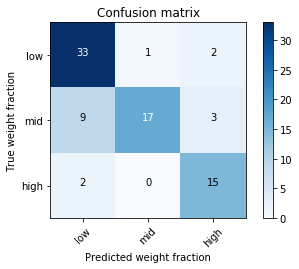

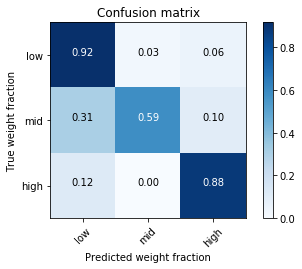

Average normalized accuracy:  0.7950755014649538


In [179]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_enm, 
                             y_training = bin_enm, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:0',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_enm, 
                                                             y_training = bin_enm, 
                                                             X_testing = X_enm, 
                                                             y_testing = bin_enm, 
                                                             file_name = 'enm_only')

{'estimator__C': 31622776.60168379, 'estimator__gamma': 3.162277660168379e-08}
accuracy
0.6463414634146342


Confusion matrix, without normalization
[[30  4  2]
 [ 8 18  3]
 [ 3  2 12]]
Normalized confusion matrix
[[0.83 0.11 0.06]
 [0.28 0.62 0.1 ]
 [0.18 0.12 0.71]]


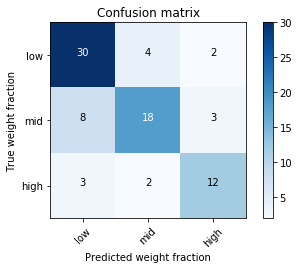

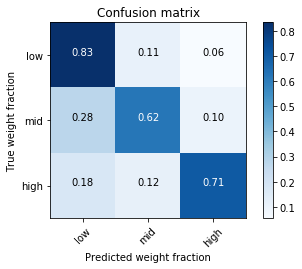

Average normalized accuracy:  0.7199684471489746


In [180]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_enm, 
                             y_training = bin_enm,
                             c_set = np.logspace(-1,9,21), 
                             gamma_set = np.logspace(-9,1,21))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:0',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_enm, 
                                                             y_training = bin_enm, 
                                                             X_testing = X_enm, 
                                                             y_testing = bin_enm, 
                                                             file_name = 'enm_only')

## ENM-only permutations

The following tests are performed with randomly permuted labels (ENM data only).

In [174]:
np.logspace(-1,9,21)

array([1.00e-01, 3.16e-01, 1.00e+00, 3.16e+00, 1.00e+01, 3.16e+01,
       1.00e+02, 3.16e+02, 1.00e+03, 3.16e+03, 1.00e+04, 3.16e+04,
       1.00e+05, 3.16e+05, 1.00e+06, 3.16e+06, 1.00e+07, 3.16e+07,
       1.00e+08, 3.16e+08, 1.00e+09])

{'estimator__C': 17782794.100389227, 'estimator__gamma': 1.995262314968883e-07}
accuracy
0.4268292682926829


Confusion matrix, without normalization
[[21  6  9]
 [ 7 15  7]
 [ 2  1 14]]
Normalized confusion matrix
[[0.58 0.17 0.25]
 [0.24 0.52 0.24]
 [0.12 0.06 0.82]]


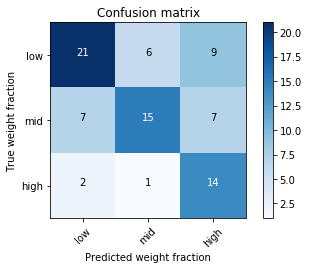

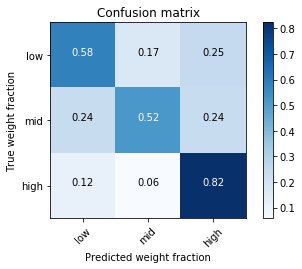

Average normalized accuracy:  0.6413680414694614


In [188]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_enm, 
                             y_training = bin_enm_permuteA, 
                             c_set = np.logspace(-1,10,21), 
                             gamma_set = np.logspace(-10,1,21))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:0*',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_enm, 
                                                             y_training = bin_enm_permuteA, 
                                                             X_testing = X_enm, 
                                                             y_testing = bin_enm_permuteA, 
                                                             file_name = 'enm_permuteA')

{'estimator__C': 10000000000.0, 'estimator__gamma': 1e-10}
accuracy
0.5365853658536586


Confusion matrix, without normalization
[[28  7  1]
 [10 18  1]
 [ 7  6  4]]
Normalized confusion matrix
[[0.78 0.19 0.03]
 [0.34 0.62 0.03]
 [0.41 0.35 0.24]]


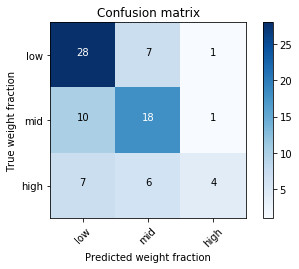

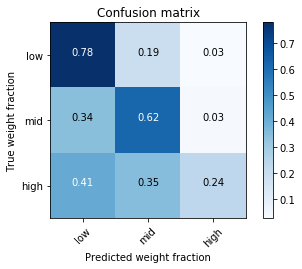

Average normalized accuracy:  0.5445871835324169


In [189]:
C, gamma = gridsearch_svcrbf(X_training = X_enm, 
                             y_training = bin_enm_permuteB, 
                             c_set = np.logspace(-1,10,21), 
                             gamma_set = np.logspace(-10,1,21))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:0*',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_enm, 
                                                             y_training = bin_enm_permuteB, 
                                                             X_testing = X_enm, 
                                                             y_testing = bin_enm_permuteB, 
                                                             file_name = 'enm_permuteB')

{'estimator__C': 17782794.100389227, 'estimator__gamma': 4.466835921509635e-09}
accuracy
0.47560975609756095


Confusion matrix, without normalization
[[24  3  9]
 [12  7 10]
 [ 6  3  8]]
Normalized confusion matrix
[[0.67 0.08 0.25]
 [0.41 0.24 0.34]
 [0.35 0.18 0.47]]


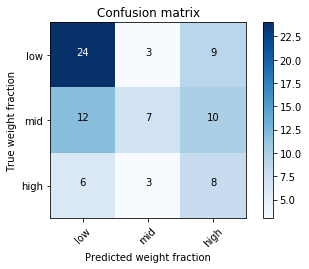

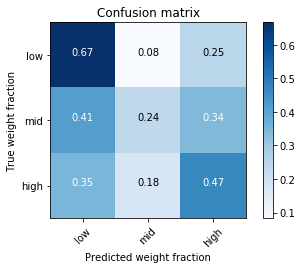

Average normalized accuracy:  0.45954473743520396


In [187]:
C, gamma = gridsearch_svcrbf(X_training = X_enm, 
                             y_training = bin_enm_permuteC, 
                             c_set = np.logspace(-1,10,21), 
                             gamma_set = np.logspace(-10,1,21))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:0*',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_enm, 
                                                             y_training = bin_enm_permuteC, 
                                                             X_testing = X_enm, 
                                                             y_testing = bin_enm_permuteC, 
                                                             file_name = 'enm_permuteC')

## 1:200 ENM-organics data

In [ ]:
### Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_all, 
                             y_training = bin_all, 
                             c_set = np.logspace(-1,6,8), 
                             gamma_set = np.logspace(-6,1,8))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:200',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_all, 
                                                         y_training = bin_all, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto200')

## 1:100 ENM-organics data

{'estimator__C': 100000.0, 'estimator__gamma': 10.0}
accuracy
0.7576672301376479


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


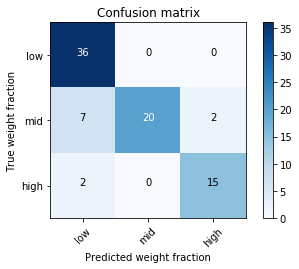

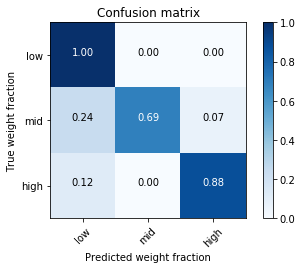

Average normalized accuracy:  0.8573360378634213


In [258]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto100a, 
                             y_training = bin_oneto100a, 
                             c_set = np.logspace(-1,6,8), 
                             gamma_set = np.logspace(-6,1,8))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:100',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto100a, 
                                        y_training = bin_oneto100a, 
                                        X_testing = X_enm, y_testing = bin_enm, file_name = 'oneto100a')

{'estimator__C': 63095.73444801943, 'estimator__gamma': 10.0}
accuracy
0.7628592127505434


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


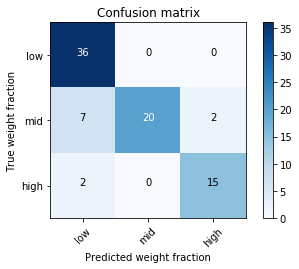

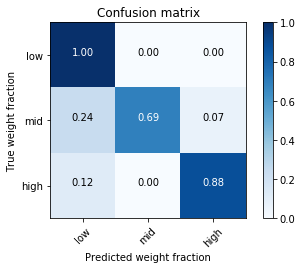

Average normalized accuracy:  0.8573360378634213


In [144]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto100b, 
                             y_training = bin_oneto100b, 
                             c_set = np.logspace(0,8,6), 
                             gamma_set = np.logspace(-6,1,6))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:100',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto100b, 
                                                         y_training = bin_oneto100b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto100b')

{'estimator__C': 63095.73444801943, 'estimator__gamma': 10.0}
accuracy
0.7503018594542381


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


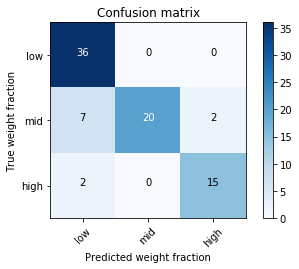

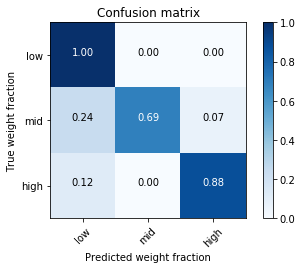

Average normalized accuracy:  0.8573360378634213


In [143]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto100c, 
                             y_training = bin_oneto100c, 
                             c_set = np.logspace(0,8,6), 
                             gamma_set = np.logspace(-6,1,6))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:100',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto100c, 
                                                         y_training = bin_oneto100c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto100c')

## 1:50 ENM-organics data

{'estimator__C': 316227.7660168379, 'estimator__gamma': 10.0}
accuracy
0.7446197991391679


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


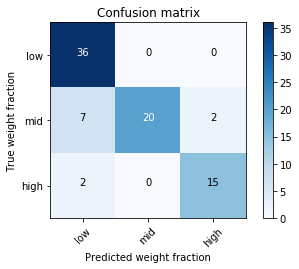

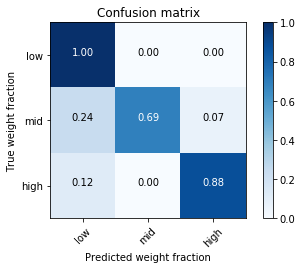

Average normalized accuracy:  0.8573360378634213


In [261]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto50a, 
                             y_training = bin_oneto50a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:50',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto50a, 
                                                         y_training = bin_oneto50a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto50a')

{'estimator__C': 100000.0, 'estimator__gamma': 10.0}
accuracy
0.7465327594452416


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


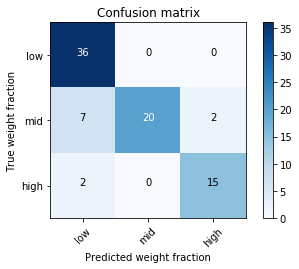

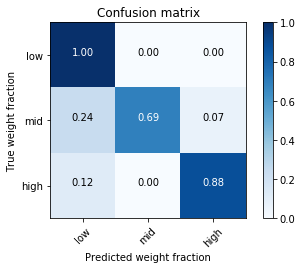

Average normalized accuracy:  0.8573360378634213


In [255]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto50b, 
                             y_training = bin_oneto50b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:50',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto50b, 
                                                         y_training = bin_oneto50b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto50b')

{'estimator__C': 100000.0, 'estimator__gamma': 10.0}
accuracy
0.7352941176470589


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


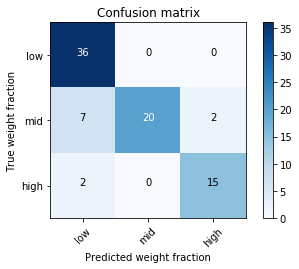

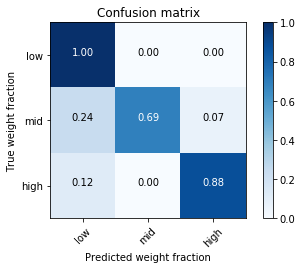

Average normalized accuracy:  0.8573360378634213


In [262]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto50c, 
                             y_training = bin_oneto50c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:50',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto50c, 
                                                         y_training = bin_oneto50c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto50c')

## 1:20 ENM-organics data

{'estimator__C': 31622.776601683792, 'estimator__gamma': 10.0}
accuracy
0.6957026713124274


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


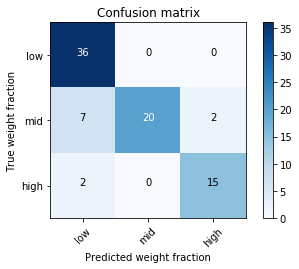

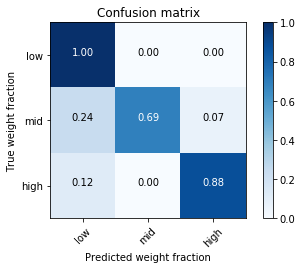

Average normalized accuracy:  0.8573360378634213


In [248]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto20a, 
                             y_training = bin_oneto20a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:20',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto20a, 
                                                         y_training = bin_oneto20a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto20a')

{'estimator__C': 316227.7660168379, 'estimator__gamma': 1.0}
accuracy
0.6875725900116144


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


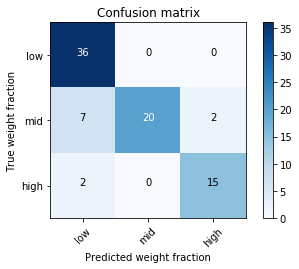

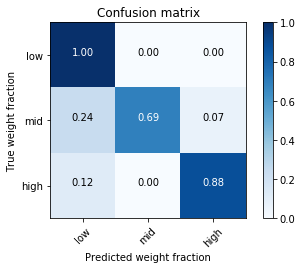

Average normalized accuracy:  0.8573360378634213


In [249]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto20b, 
                             y_training = bin_oneto20b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:20',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto20b, 
                                                         y_training = bin_oneto20b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto20b')

{'estimator__C': 100000.0, 'estimator__gamma': 10.0}
accuracy
0.6974448315911731


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


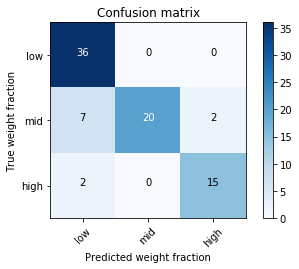

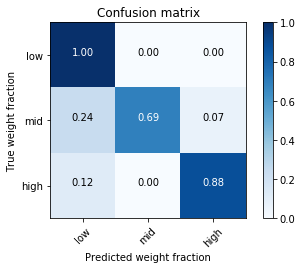

Average normalized accuracy:  0.8573360378634213


In [250]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto20c, 
                             y_training = bin_oneto20c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:20',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto20c, 
                                                         y_training = bin_oneto20c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto20c')

## 1:10 ENM-organics data

{'estimator__C': 3.1622776601683795, 'estimator__gamma': 10.0}
accuracy
0.6696230598669624


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


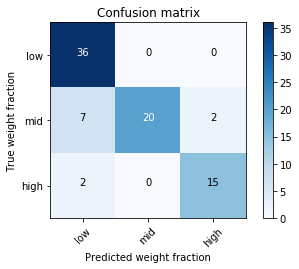

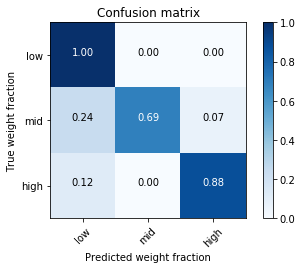

Average normalized accuracy:  0.8573360378634213


In [191]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto10a, 
                             y_training = bin_oneto10a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:10',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto10a, 
                                                         y_training = bin_oneto10a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto10a')

{'estimator__C': 3162.2776601683795, 'estimator__gamma': 10.0}
accuracy
0.6929046563192904


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


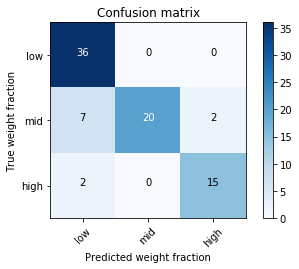

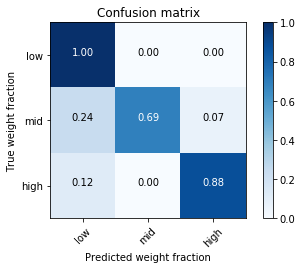

Average normalized accuracy:  0.8573360378634213


In [192]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto10b, 
                             y_training = bin_oneto10b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:10',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto10b, 
                                                         y_training = bin_oneto10b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto10b')

{'estimator__C': 1000.0, 'estimator__gamma': 1.0}
accuracy
0.6574279379157428


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


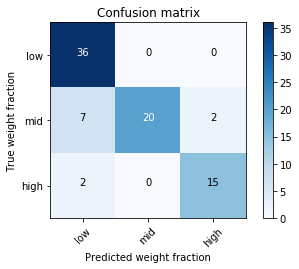

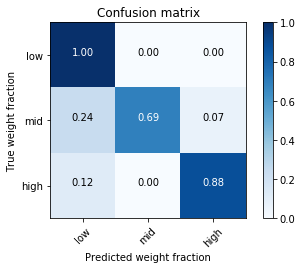

Average normalized accuracy:  0.8573360378634213


In [194]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto10c, 
                             y_training = bin_oneto10c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:10',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto10c, 
                                                         y_training = bin_oneto10c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto10c')

## 1:5 ENM-organics data

{'estimator__C': 316.22776601683796, 'estimator__gamma': 1.0}
accuracy
0.6239837398373984


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


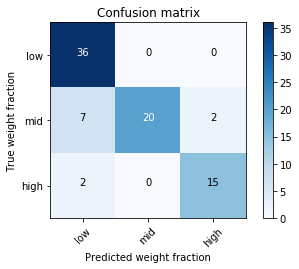

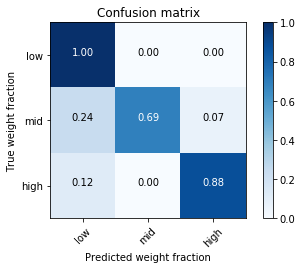

Average normalized accuracy:  0.8573360378634213


In [197]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto5a, 
                             y_training = bin_oneto5a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:5',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto5a, 
                                                         y_training = bin_oneto5a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto5a')

{'estimator__C': 100000.0, 'estimator__gamma': 10.0}
accuracy
0.6138211382113821


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


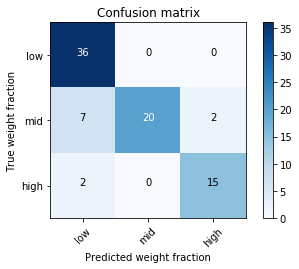

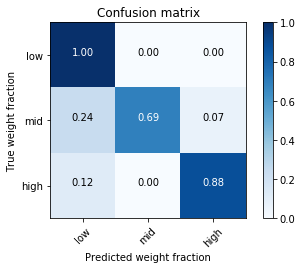

Average normalized accuracy:  0.8573360378634213


In [198]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto5b, 
                             y_training = bin_oneto5b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:5',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto5b, 
                                                         y_training = bin_oneto5b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto5b')

{'estimator__C': 10000.0, 'estimator__gamma': 1.0}
accuracy
0.6666666666666666


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


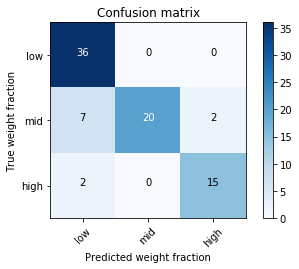

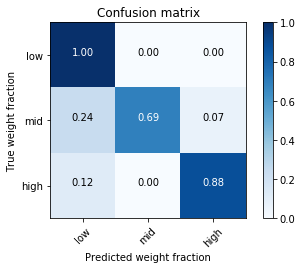

Average normalized accuracy:  0.8573360378634213


In [199]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto5c, 
                             y_training = bin_oneto5c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:5',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto5c, 
                                                         y_training = bin_oneto5c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto5c')

## 1:4 ENM-organics data

{'estimator__C': 316.22776601683796, 'estimator__gamma': 10.0}
accuracy
0.6292682926829268


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


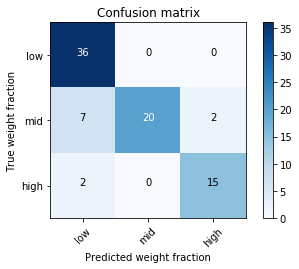

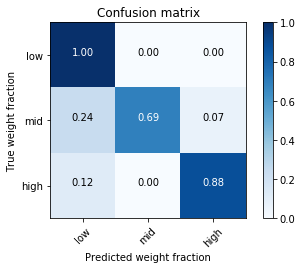

Average normalized accuracy:  0.8573360378634213


In [233]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto4a, 
                             y_training = bin_oneto4a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:4',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto4a, 
                                                         y_training = bin_oneto4a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto4a')

{'estimator__C': 3162.2776601683795, 'estimator__gamma': 3.1622776601683795}
accuracy
0.6317073170731707


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


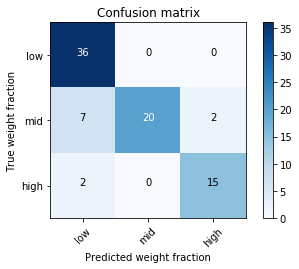

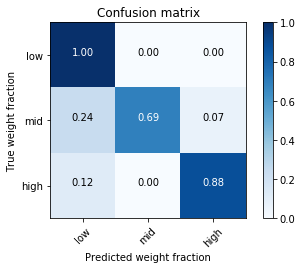

Average normalized accuracy:  0.8573360378634213


In [234]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto4b, 
                             y_training = bin_oneto4b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:4',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto4b, 
                                                         y_training = bin_oneto4b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto4b')

{'estimator__C': 1.0, 'estimator__gamma': 10.0}
accuracy
0.6146341463414634


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


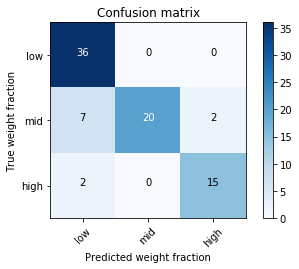

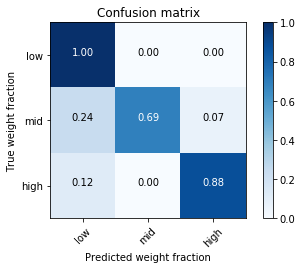

Average normalized accuracy:  0.8573360378634213


In [235]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto4c, 
                             y_training = bin_oneto4c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:4',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto4c, 
                                                         y_training = bin_oneto4c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto4c')

## 1:3 ENM-organics data

{'estimator__C': 1000.0, 'estimator__gamma': 10.0}
accuracy
0.6280487804878049


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


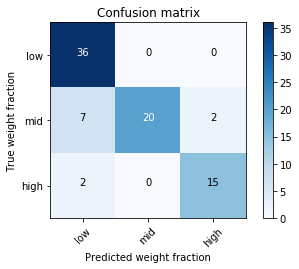

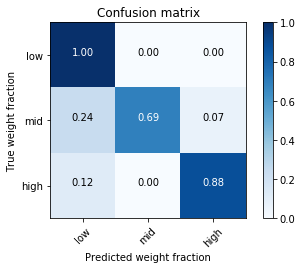

Average normalized accuracy:  0.8573360378634213


In [237]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto3a, 
                             y_training = bin_oneto3a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:3',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto3a, 
                                                                         y_training = bin_oneto3a, 
                                                                         X_testing = X_enm, 
                                                                         y_testing = bin_enm, 
                                                                         file_name = 'oneto3a')

{'estimator__C': 3.1622776601683795, 'estimator__gamma': 10.0}
accuracy
0.5884146341463414


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


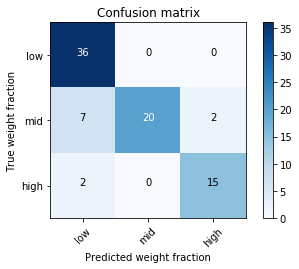

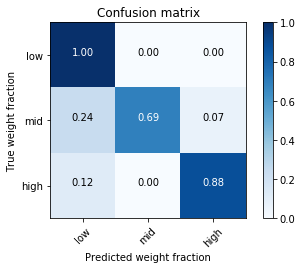

Average normalized accuracy:  0.8573360378634213


In [238]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto3b, 
                             y_training = bin_oneto3b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:3',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto3b, 
                                                         y_training = bin_oneto3b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto3b')

{'estimator__C': 0.1, 'estimator__gamma': 0.31622776601683794}
accuracy
0.5975609756097561


Confusion matrix, without normalization
[[34  2  0]
 [13 13  3]
 [ 5  8  4]]
Normalized confusion matrix
[[0.94 0.06 0.  ]
 [0.45 0.45 0.1 ]
 [0.29 0.47 0.24]]


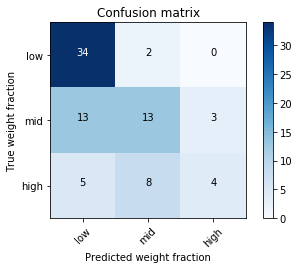

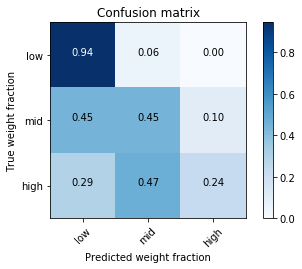

Average normalized accuracy:  0.5426714747201563


In [239]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto3c, 
                             y_training = bin_oneto3c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:3',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto3c, 
                                                         y_training = bin_oneto3c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto3c')

## 1:2 ENM-organics data

{'estimator__C': 10.0, 'estimator__gamma': 0.31622776601683794}
accuracy
0.6504065040650406


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


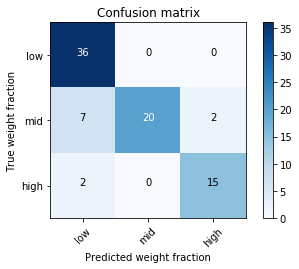

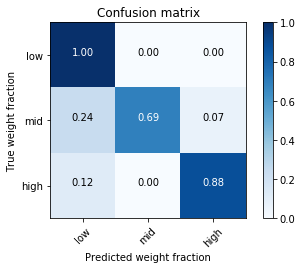

Average normalized accuracy:  0.8573360378634213


In [240]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto2a, 
                             y_training = bin_oneto2a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:2',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto2a, 
                                                         y_training = bin_oneto2a, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto2a')

{'estimator__C': 1.0, 'estimator__gamma': 1.0}
accuracy
0.6341463414634146


Confusion matrix, without normalization
[[36  0  0]
 [ 8 19  2]
 [ 3  0 14]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.28 0.66 0.07]
 [0.18 0.   0.82]]


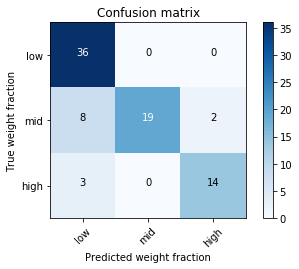

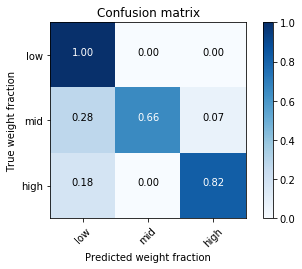

Average normalized accuracy:  0.8262339418526031


In [241]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto2b, 
                             y_training = bin_oneto2b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:2',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto2b, 
                                                         y_training = bin_oneto2b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto2b')

{'estimator__C': 1.0, 'estimator__gamma': 10.0}
accuracy
0.5934959349593496


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


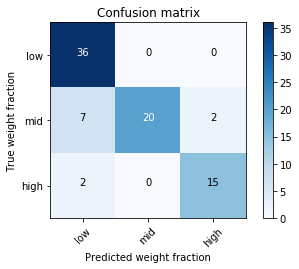

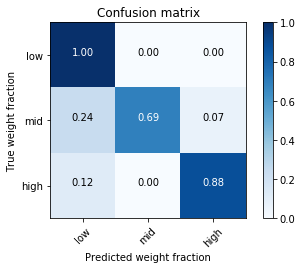

Average normalized accuracy:  0.8573360378634213


In [242]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto2c, 
                             y_training = bin_oneto2c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:2',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto2c, 
                                                         y_training = bin_oneto2c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto2c')

## 1:1 ENM-organics data

{'estimator__C': 316.22776601683796, 'estimator__gamma': 10.0}
accuracy
0.5304878048780488


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


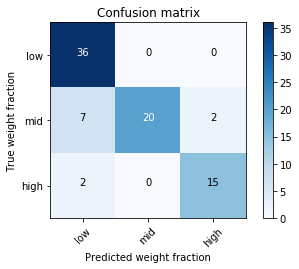

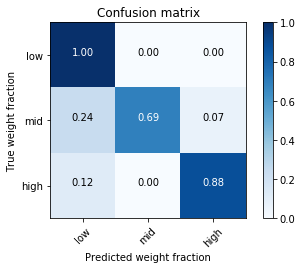

Average normalized accuracy:  0.8573360378634213


In [243]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_oneto1a, 
                             y_training = bin_oneto1a, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:1',
               'Random-Augment-A'] = confusion_matrix_cv(X_training = X_oneto1a, 
                                                                         y_training = bin_oneto1a, 
                                                                         X_testing = X_enm, 
                                                                         y_testing = bin_enm, 
                                                                         file_name = 'oneto1a')

{'estimator__C': 1.0, 'estimator__gamma': 0.01}
accuracy
0.5792682926829268


Confusion matrix, without normalization
[[36  0  0]
 [19  0 10]
 [ 9  0  8]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.66 0.   0.34]
 [0.53 0.   0.47]]


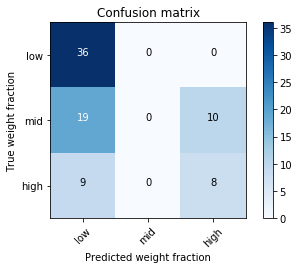

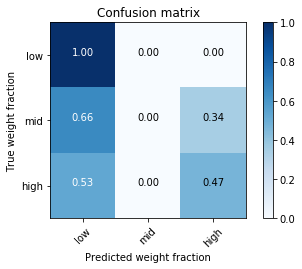

Average normalized accuracy:  0.4901960784313726


In [244]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto1b, 
                             y_training = bin_oneto1b, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:1',
               'Random-Augment-B'] = confusion_matrix_cv(X_training = X_oneto1b, 
                                                         y_training = bin_oneto1b, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto1b')

{'estimator__C': 10.0, 'estimator__gamma': 3.1622776601683795}
accuracy
0.5670731707317073


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


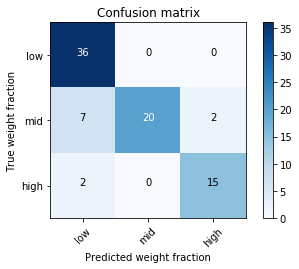

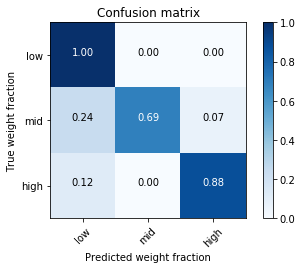

Average normalized accuracy:  0.8573360378634213


In [245]:
C, gamma = gridsearch_svcrbf(X_training = X_oneto1c, 
                             y_training = bin_oneto1c, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

results_df.loc[results_df['ENM-Organics-Ratio']=='1:1',
               'Random-Augment-C'] = confusion_matrix_cv(X_training = X_oneto1c, 
                                                         y_training = bin_oneto1c, 
                                                         X_testing = X_enm, 
                                                         y_testing = bin_enm, 
                                                         file_name = 'oneto1c')

## Matching 1:50

{'estimator__C': 31622.776601683792, 'estimator__gamma': 3.1622776601683795}
accuracy
0.6939263510282162


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


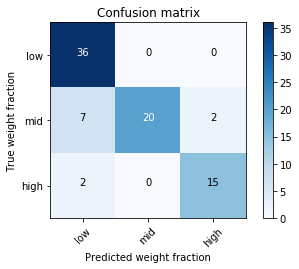

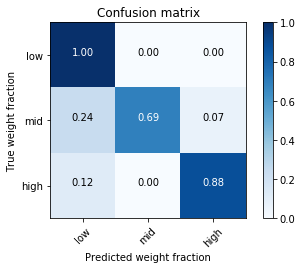

Average normalized accuracy:  0.8573360378634213


In [170]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match50, 
                             y_training = bin_match50, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:50',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match50, 
                                                              y_training = bin_match50, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match50')

## Matching 1:20

{'estimator__C': 100.0, 'estimator__gamma': 10.0}
accuracy
0.6713124274099884


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


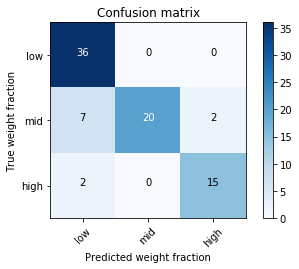

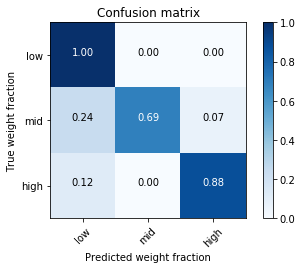

Average normalized accuracy:  0.8573360378634213


In [171]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match20, 
                             y_training = bin_match20, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:20',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match20, 
                                                              y_training = bin_match20, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match20')

## Matching 1:10

{'estimator__C': 31.622776601683793, 'estimator__gamma': 10.0}
accuracy
0.6984478935698448


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


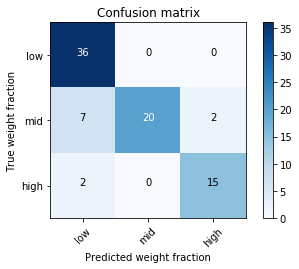

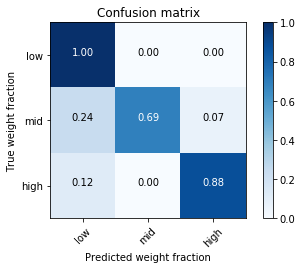

Average normalized accuracy:  0.8573360378634213


In [172]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match10, 
                             y_training = bin_match10, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:10',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match10, 
                                                              y_training = bin_match10, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match10')

## Matching 1:5

{'estimator__C': 31.622776601683793, 'estimator__gamma': 10.0}
accuracy
0.725609756097561


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


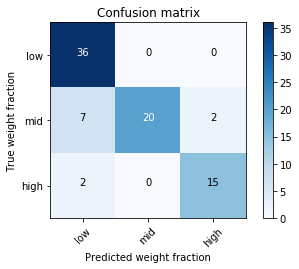

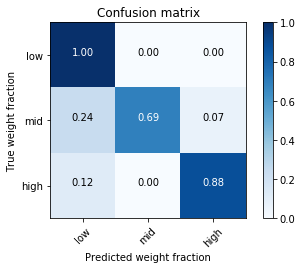

Average normalized accuracy:  0.8573360378634213


In [153]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match5, 
                             y_training = bin_match5, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:5',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match5, 
                                                              y_training = bin_match5, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match5')

## Matching 1:4

{'estimator__C': 316227.7660168379, 'estimator__gamma': 0.01}
accuracy
0.697560975609756


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


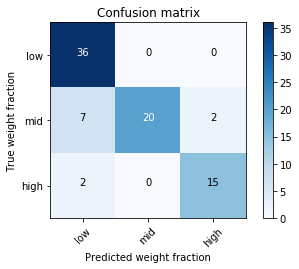

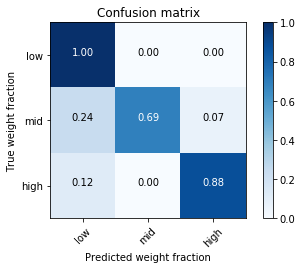

Average normalized accuracy:  0.8573360378634213


In [164]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match4, 
                             y_training = bin_match4, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:4',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match4, 
                                                              y_training = bin_match4, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match4')

## Matching 1:3

{'estimator__C': 3162.2776601683795, 'estimator__gamma': 0.1}
accuracy
0.7225609756097561


Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


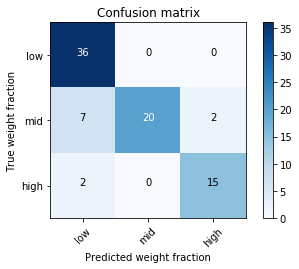

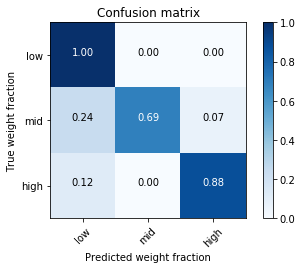

Average normalized accuracy:  0.8573360378634213


In [166]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match3, 
                             y_training = bin_match3, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:3',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match3, 
                                                              y_training = bin_match3, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match3')

## Matching 1:2

{'estimator__C': 1000000.0, 'estimator__gamma': 0.0001}
accuracy
0.7032520325203252


Confusion matrix, without normalization
[[36  0  0]
 [11 15  3]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.38 0.52 0.1 ]
 [0.12 0.   0.88]]


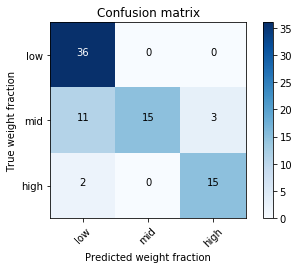

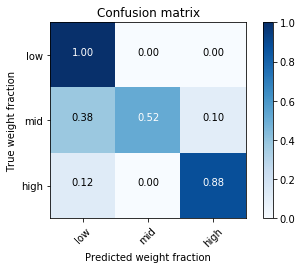

Average normalized accuracy:  0.7998647734956051


In [167]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match2, 
                             y_training = bin_match2, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:2',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match2, 
                                                              y_training = bin_match2, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match2')

## Matching 1:1

{'estimator__C': 10000.0, 'estimator__gamma': 0.0031622776601683794}
accuracy
0.676829268292683


Confusion matrix, without normalization
[[36  0  0]
 [ 8 18  3]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.28 0.62 0.1 ]
 [0.12 0.   0.88]]


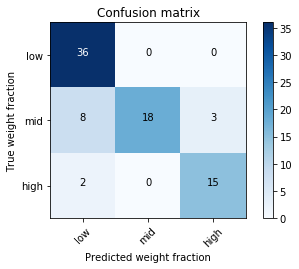

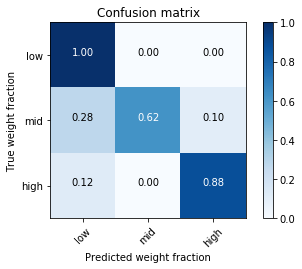

Average normalized accuracy:  0.8343475321162948


In [168]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_match1, 
                             y_training = bin_match1, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:1',
               'Match-Feature-Augment'] = confusion_matrix_cv(X_training = X_match1, 
                                                              y_training = bin_match1, 
                                                              X_testing = X_enm, 
                                                              y_testing = bin_enm, 
                                                              file_name = 'match1')

## Matching label 1:50

{'estimator__C': 1000000.0, 'estimator__gamma': 0.31622776601683794}
accuracy
0.7422285987565758


Confusion matrix, without normalization
[[28  6  2]
 [ 2 25  2]
 [ 0  1 16]]
Normalized confusion matrix
[[0.78 0.17 0.06]
 [0.07 0.86 0.07]
 [0.   0.06 0.94]]


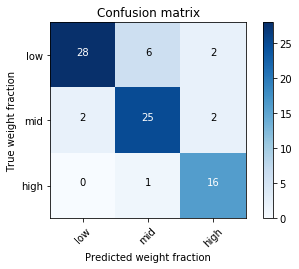

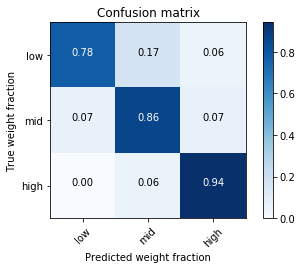

Average normalized accuracy:  0.8603410712944181


In [161]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab50, 
                             y_training = bin_matchlab50, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:50',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab50, 
                                                            y_training = bin_matchlab50, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab50')

## Matching label 1:20

{'estimator__C': 1000000.0, 'estimator__gamma': 0.1}
accuracy
0.7125435540069687


Confusion matrix, without normalization
[[28  6  2]
 [ 2 25  2]
 [ 0  1 16]]
Normalized confusion matrix
[[0.78 0.17 0.06]
 [0.07 0.86 0.07]
 [0.   0.06 0.94]]


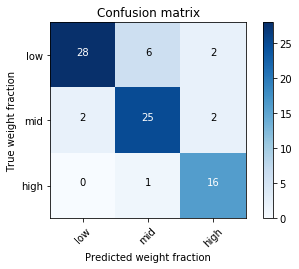

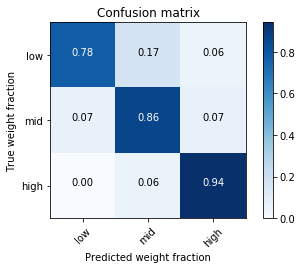

Average normalized accuracy:  0.8603410712944181


In [160]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab20, 
                             y_training = bin_matchlab20, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:20',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab20, 
                                                            y_training = bin_matchlab20, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab20')

## Matching label 1:10

{'estimator__C': 31622.776601683792, 'estimator__gamma': 0.1}
accuracy
0.770509977827051


Confusion matrix, without normalization
[[28  6  2]
 [ 2 25  2]
 [ 0  1 16]]
Normalized confusion matrix
[[0.78 0.17 0.06]
 [0.07 0.86 0.07]
 [0.   0.06 0.94]]


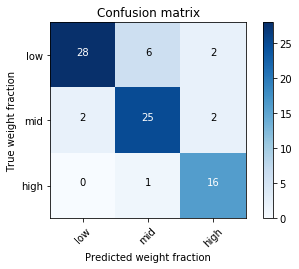

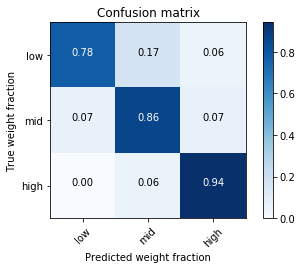

Average normalized accuracy:  0.8603410712944181


In [159]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab10, 
                             y_training = bin_matchlab10, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:10',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab10, 
                                                            y_training = bin_matchlab10, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab10')

## Matching label 1:5

{'estimator__C': 10000.0, 'estimator__gamma': 0.1}
accuracy
0.6971544715447154


Confusion matrix, without normalization
[[28  6  2]
 [ 2 25  2]
 [ 0  1 16]]
Normalized confusion matrix
[[0.78 0.17 0.06]
 [0.07 0.86 0.07]
 [0.   0.06 0.94]]


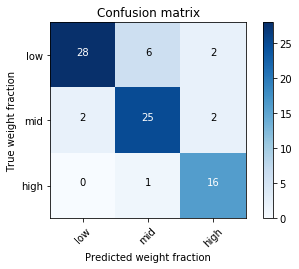

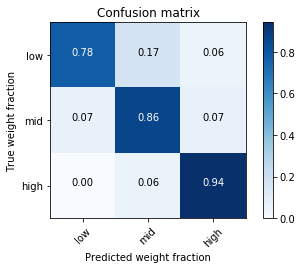

Average normalized accuracy:  0.8603410712944181


In [154]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab5, 
                             y_training = bin_matchlab5, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:5',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab5, 
                                                            y_training = bin_matchlab5, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab5')

## Matching label 1:4

{'estimator__C': 100.0, 'estimator__gamma': 0.03162277660168379}
accuracy
0.751219512195122


Confusion matrix, without normalization
[[26  7  3]
 [ 2 25  2]
 [ 0  1 16]]
Normalized confusion matrix
[[0.72 0.19 0.08]
 [0.07 0.86 0.07]
 [0.   0.06 0.94]]


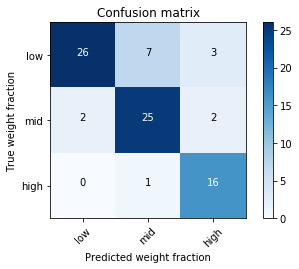

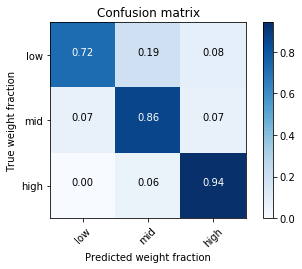

Average normalized accuracy:  0.8418225527758997


In [155]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab4, 
                             y_training = bin_matchlab4, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:4',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab4, 
                                                            y_training = bin_matchlab4, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab4')

## Matching label 1:3

{'estimator__C': 10.0, 'estimator__gamma': 0.1}
accuracy
0.7378048780487805


Confusion matrix, without normalization
[[27  7  2]
 [ 2 24  3]
 [ 2  1 14]]
Normalized confusion matrix
[[0.75 0.19 0.06]
 [0.07 0.83 0.1 ]
 [0.12 0.06 0.82]]


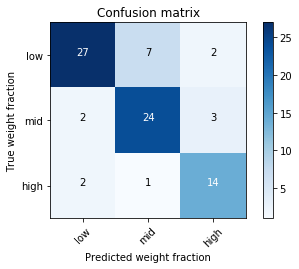

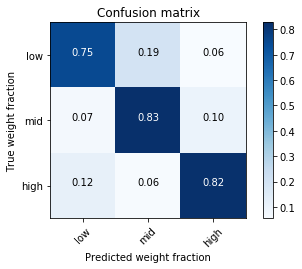

Average normalized accuracy:  0.8003718728870858


In [156]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab3, 
                             y_training = bin_matchlab3, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:3',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab3, 
                                                            y_training = bin_matchlab3, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab3')

## Matching label 1:2

{'estimator__C': 316227.7660168379, 'estimator__gamma': 0.001}
accuracy
0.6707317073170732


Confusion matrix, without normalization
[[33  0  3]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[0.92 0.   0.08]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


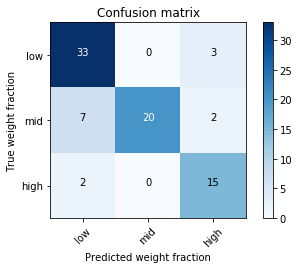

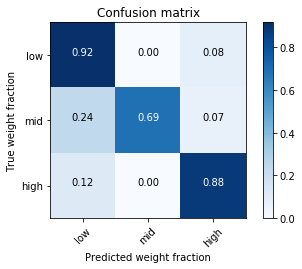

Average normalized accuracy:  0.8295582600856434


In [157]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab2, 
                             y_training = bin_matchlab2, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:2',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab2, 
                                                            y_training = bin_matchlab2, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab2')

## Matching label 1:1

{'estimator__C': 31.622776601683793, 'estimator__gamma': 0.1}
accuracy
0.6646341463414634


Confusion matrix, without normalization
[[34  0  2]
 [ 7 20  2]
 [ 1  0 16]]
Normalized confusion matrix
[[0.94 0.   0.06]
 [0.24 0.69 0.07]
 [0.06 0.   0.94]]


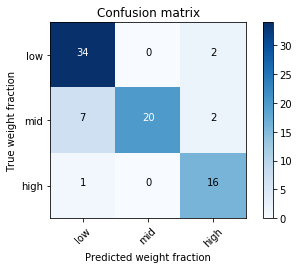

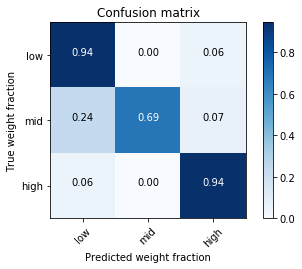

Average normalized accuracy:  0.8584253624821576


In [158]:
# Get optimized parameters for SVC-RBF
C, gamma = gridsearch_svcrbf(X_training = X_matchlab1, 
                             y_training = bin_matchlab1, 
                             c_set = np.logspace(-1,6,15), 
                             gamma_set = np.logspace(-6,1,15))

# Apply SVC-RBF model; summarize performance in confusion matrices;
# Assign the normalized average accuracy to results table
results_df.loc[results_df['ENM-Organics-Ratio']=='1:1',
               'Match-Label-Augment'] = confusion_matrix_cv(X_training = X_matchlab1, 
                                                            y_training = bin_matchlab1, 
                                                            X_testing = X_enm, 
                                                            y_testing = bin_enm, 
                                                            file_name = 'matchlab1')

## Performance Results

The following table summarizes the average normalized accuracy for SVC-RBF models on all data frames.
* 'ENM-Organics-Ratio' describes the ratio of ENM data to organics data used for augmentation. 
* 'Percent-Organics' is a similar descriptor, but explains what percent of the orginal 16,354 organics data points were used for augmenting the ENM data.
* An ENM-Organics-Ratio with ( * ) indicates that the labels were randomly permuted
* 'Match-Feature-Augment' is average accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features.
* 'Match-Label-Augment' is average accuracy across all bins for data frames with ENM data augmented with organics data based on the closest matching features AND labels (weighted 1:1).
* The second trial (B) of the ENM-only data (1:0 ratio) is with different a different parameter grid for optimizing the SVC-RBF.

Matching augmentation was not performed on data frames only containing ENM data (non-permuted and permuted).

In [263]:
# Calculate average and standard deviation of random augmentation accuracy results
results_df['Avg-Random-Augment'] = results_df.iloc[:,2:5].mean(axis=1)
results_df['Std-Random-Augment'] = results_df.iloc[:,2:5].std(axis=1).round(decimals=6)

# Set multi-index
results_df.set_index(['ENM-Organics-Ratio']) #, 'Percent-Organics'

# Color results as heatmap
results_df.style.background_gradient(cmap='Wistia').set_precision(3) #, subset=results_df.iloc[:, 2:]

/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


,ENM-Organics-Ratio,Percent-Organics,Random-Augment-A,Random-Augment-B,Random-Augment-C,Avg-Random-Augment,Std-Random-Augment,Match-Feature-Augment,Match-Label-Augment
0,1:200,100,0.465,nan,nan,0.465,nan,nan,nan
1,1:100,50,0.857,0.857,0.857,0.857,0,nan,nan
2,1:50,25,0.857,0.857,0.857,0.857,0,0.857,0.86
3,1:20,10,0.857,0.857,0.857,0.857,0,0.857,0.86
4,1:10,5,0.857,0.857,0.857,0.857,0,0.857,0.86
5,1:5,2.5,0.857,0.857,0.857,0.857,0,0.857,0.86
6,1:4,2,0.857,0.857,0.857,0.857,0,0.857,0.842
7,1:3,1.5,0.857,0.857,0.543,0.752,0.182,0.857,0.8
8,1:2,1,0.857,0.826,0.857,0.847,0.018,0.8,0.83
9,1:1,0.5,0.857,0.49,0.857,0.735,0.212,0.834,0.858


In [264]:
# Export results table to .csv
results_df.to_csv("./data/2019-02-18_augment_results.csv", 
                  sep='\t', header='infer', na_rep='NaN', index=False)

# Random Forest Models

In [186]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Pipeline
estimator = RandomForestClassifier()
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv = 10
n_jobs = 3
n_set = [8,10,12,14,16,18,20,22,24,26]

# Gridsearch
param_grid={'estimator__n_estimators': n_set}
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_enm+0.00001,bin_enm)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__n_estimators': 20}
0.5853658536585366
accuracy


In [202]:
# SVR-RBF with all features, normalized
    # ENM weight fractions
    # Accuracy

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

# Pipeline
estimator = RandomForestClassifier()
prepipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', estimator)
])

# Set parameter ranges for gridsearch
cv = 10
n_jobs = 3
n_set = [8,10,12,14,16,18,20,22,24,26,28,30,32]

# Gridsearch
param_grid={'estimator__n_estimators': n_set}
grid_search=GridSearchCV(prepipe,param_grid,cv=cv,scoring='accuracy', n_jobs=n_jobs, pre_dispatch=2*n_jobs)
grid_search.fit(X_match2+0.00001,bin_match2)
print(grid_search.best_params_)
print(grid_search.best_score_)
print(grid_search.scoring)

# Play sound when done running
Audio(url=sound_file, autoplay=True)

{'estimator__n_estimators': 28}
0.6869918699186992
accuracy


In [205]:
grid_search.best_params_.get('estimator__n_estimators')

28

In [206]:
# Final pipeline
bestpipe = Pipeline([
    ('scale', MinMaxScaler()),
    ('estimator', RandomForestClassifier(
        n_estimators = grid_search.best_params_.get('estimator__n_estimators')))
     ])
bestpipe.fit(X_match2,bin_match2)

Pipeline(memory=None,
     steps=[('scale', MinMaxScaler(copy=True, feature_range=(0, 1))), ('estimator', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
           ...n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))])

Confusion matrix, without normalization
[[36  0  0]
 [ 7 20  2]
 [ 2  0 15]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.24 0.69 0.07]
 [0.12 0.   0.88]]


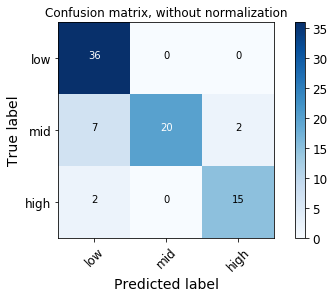

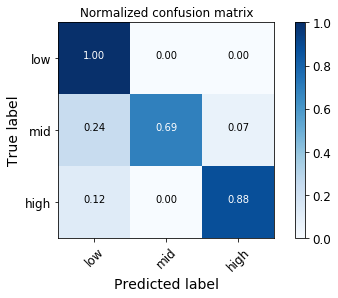

In [204]:
# Cross-validation for confusion matrix
from sklearn import model_selection

X=np.array(X_enm)
y=np.array(bin_enm)

kfold = model_selection.StratifiedKFold(n_splits=17,shuffle=True, random_state=24)
cnf_matrix2=np.zeros([3,3])

for train_index,test_index in kfold.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    y_enm_predict=bestpipe.predict(X_test)
    y[test_index]=y_enm_predict
    cnf_matrix2+= confusion_matrix(y_test, y_enm_predict);
    
# Set confusion matrix
cnf_matrix=cnf_matrix2.astype(np.int)
cnf_matrix = confusion_matrix(bin_enm, y)

np.set_printoptions(precision=2)
class_names=["low","mid","high"]

# Plot non-normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
fig.savefig('./BLTfigs/confusion_notnorm_mix_match2.png')

# Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
fig.savefig('./BLTfigs/confusion_norm_mix_match2.png')
plt.show()